In [ ]:
# Initial Setup: Imports and Device Configuration

!pip install torch torchvision # Install necessary libraries: PyTorch and TorchVision

import torch # Import the PyTorch library
import torch.nn as nn # Import the neural network module
import torch.nn.functional as F # Import the functional module (e.g., activation functions)
import numpy as np # Import the NumPy library for numerical operations
from sklearn.metrics.pairwise import cosine_similarity # Import cosine_similarity for calculating similarity
from torch.optim import Adam # Import the Adam optimizer
import random # Import the random module for random operations
import copy # Import the copy module for deep copying objects
import torchvision.transforms as transforms # Import transforms module
from torchvision.datasets import MNIST # Import MNIST dataset
from torch.utils.data import DataLoader # Import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset # Import Subset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Import pandas for rolling average
from scipy.optimize import curve_fit # Import curve_fit for more flexible fitting

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Determine the device to use (GPU or CPU)
print(f"Using device: {device}") # Print the device being used

Using device: cpu


In [ ]:
# Experience Buffer Class and Model Definitions
# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Determine the device to use (GPU or CPU)

# Define a class to store individual experiences
class Experience: # Class definition for an Experience object
    # Constructor to initialize an Experience object
    def __init__(self, features, label, confidence, timestamp, image_tensor):
        self.features = features.cpu() # Store the feature vector on the CPU
        self.label = label # Store the true label
        self.confidence = confidence # Store the confidence score
        self.timestamp = timestamp # Store the timestamp
        self.seen_count = 1 # Initialize the seen count to 1
        self.image_tensor = image_tensor.cpu() # Store the original image tensor on the CPU


# Define the Experience Buffer class
class ExperienceBuffer: # Class definition for the Experience Buffer
    # Constructor to initialize the Experience Buffer
    # Accepts the main model, RL actor, RL critic, device, max size, and meta learning rate (though meta_lr is not used now)
    def __init__(self, model, rl_actor, rl_critic, device='cpu', max_size=20, meta_lr=0.001):
        self.buffer = [] # Initialize an empty list to hold experiences
        self.max_size = max_size # Set the maximum size of the buffer
        self.model = model.to(device) # Move the main model to the specified device
        self.device = device # Store the device
        self.timestamp_counter = 0 # Initialize the timestamp counter
        # Assign the provided RL actor and critic, and move them to the device
        self.rl_actor = rl_actor.to(device)
        self.rl_critic = rl_critic.to(device)
        # Removed meta_lr and optimizer related to MetaDecisionNet
        # self.policy = MetaDecisionNet().to(device)
        # self.optimizer = Adam(self.policy.parameters(), lr=meta_lr)
        self.replay_batch_size = 5 # Define the batch size for simulated replay
        self.loss_fn = nn.CrossEntropyLoss() # Define the loss function for simulated replay
        self.epsilon = 0.5 # Define epsilon for epsilon-greedy exploration

    # Method to extract features from an input tensor using the main model
    def _extract_features(self, x):
        # Extract features from model penultimate layer (embedding)
        # Assumes model has 'extract_features' method or modify model accordingly
        self.model.eval() # Set the model to evaluation mode for feature extraction
        with torch.no_grad(): # Disable gradient calculation for efficiency
            # Removed .unsqueeze(0) from x
            x = x.to(self.device) # Move the input tensor to the device
            # Get embedding, e.g., before final layer logits
            # If your model doesn't have extract_features, you might need to modify it # Note about model modification
            # or get features from a specific layer manually
            # For this example, we'll get the output of fc1
            features = self.model.get_features(x) # Call the model's get_features method
        return features.squeeze(0) # Return the features, removing the batch dimension if present

    # Method to calculate the entropy of probability distribution
    def _entropy(self, probs):
        # Calculate entropy: -sum(p * log(p))
        return -torch.sum(probs * torch.log(probs + 1e-8)).item() # Compute and return entropy, adding epsilon for stability

    # Method to calculate the redundancy score of a new sample relative to the buffer
    def _redundancy_score(self, features):
        if not self.buffer: # Check if the buffer is empty
            return 0.0 # Return 0 if buffer is empty
        new_feat = features.cpu().numpy().reshape(1, -1) # Convert new features to NumPy array and reshape
        buffer_feats = [exp.features.numpy().reshape(1, -1) for exp in self.buffer] # Get features from buffer, convert to NumPy and reshape
        sims = [cosine_similarity(new_feat, b)[0][0] for b in buffer_feats] # Calculate cosine similarity between new features and buffer features
        return max(sims) # Return the maximum similarity score

    # Method to sample a batch of features and labels from the buffer
    def sample_batch(self, batch_size=5):
        if not self.buffer or len(self.buffer) < batch_size: # Check if buffer has enough samples
            return None, None # Return None if not enough samples
        indices = random.sample(range(len(self.buffer)), min(batch_size, len(self.buffer))) # Randomly sample indices from the buffer
        for i in indices: # Iterate through sampled indices
            self.buffer[i].seen_count += 1 # Increment the seen count for sampled experiences
        features = torch.stack([self.buffer[i].features for i in indices]).to(self.device) # Move features to device
        labels = torch.tensor([self.buffer[i].label for i in indices]).to(self.device) # Move labels to device
        return features, labels # Return the sampled features and labels

    # Method to sample a batch of image tensors and labels from the buffer
    def sample_batch_images(self, batch_size=5):
        # New method to sample image tensors and labels from the buffer
        if not self.buffer or len(self.buffer) < batch_size: # Check if buffer has enough samples
            return None, None # Return None if not enough samples
        indices = random.sample(range(len(self.buffer)), min(batch_size, len(self.buffer)))
        for i in indices: # Iterate through sampled indices
            self.buffer[i].seen_count += 1 # Increment the seen count for sampled experiences
        # Ensure the image tensors are stacked correctly (remove the extra dimension if present)
        images = torch.stack([self.buffer[i].image_tensor for i in indices]).squeeze(1).to(self.device) # Move images to device
        labels = torch.tensor([self.buffer[i].label for i in indices]).to(self.device) # Move labels to device
        return images, labels # Return the sampled image tensors and labels


    def show_status(self, num_to_show=None):
        print(f"\nBuffer has {len(self.buffer)} examples.") # Print the current size of the buffer
        if num_to_show is None: # Check if number of samples to show is specified
            num_to_show = len(self.buffer) # If not specified, show all samples
        for i, exp in enumerate(self.buffer[:num_to_show]): # Iterate through the specified number of samples
            print(f"{i+1}: Label={exp.label}, Confidence={exp.confidence:.3f}, Seen={exp.seen_count}") # Print details of each sample

    # Method to simulate a reward based on the potential improvement in model confidence after replay
    def _simulate_reward(self, accepted, image_tensor, label): # Method definition
        """Use a cloned model for safe quick replay without polluting main model.""" # Docstring
        # Reward calculation logic remains similar, but it's now used for the RL agent's training
        if not accepted or len(self.buffer) < self.replay_batch_size: # Check if sample was accepted and buffer has enough samples for replay
            return 0.0 # Return 0.0 reward if conditions are not met

        model_clone = copy.deepcopy(self.model) # Create a deep copy of the main model
        model_clone.to(self.device) # Move the cloned model to the device
        model_clone.eval() # Set the cloned model to evaluation mode

        with torch.no_grad(): # Disable gradient calculation
            # Removed .unsqueeze(0) from image_tensor
            input_tensor = image_tensor.unsqueeze(0).to(self.device) if image_tensor.dim() == 3 else image_tensor.to(self.device) # Prepare the input tensor
            pre_logit = model_clone(input_tensor) # Get logits from cloned model before replay
            pre_prob = F.softmax(pre_logit, dim=1)[0, label].item() # Get probability of the true label before replay

        # Replay training step on clone
        # Sample image tensors and labels from the buffer
        images, labels = self.sample_batch_images(self.replay_batch_size) # Get a batch of images and labels from the buffer
        if images is not None: # Check if sampling was successful
            model_clone.train() # Set the cloned model to training mode
            # Use sampled image tensors for the cloned model training
            logits = model_clone(images.to(self.device)) # Get logits for the sampled batch
            loss = self.loss_fn(logits, labels.to(self.device)) # Calculate the loss
            model_clone.zero_grad() # Zero gradients
            loss.backward() # Perform backpropagation
            for p in model_clone.parameters(): # Iterate through cloned model parameters
                if p.grad is not None: # Check if parameter has gradients
                    # Simple SGD update for simulation
                    p.data.sub_(0.001 * p.grad.data) # Perform a simple SGD parameter update

        model_clone.eval() # Set the cloned model back to evaluation mode
        with torch.no_grad(): # Disable gradient calculation
            # Removed .unsqueeze(0) from image_tensor
            input_tensor = image_tensor.unsqueeze(0).to(self.device) if image_tensor.dim() == 3 else image_tensor.to(self.device) # Prepare the input tensor
            post_logit = model_clone(input_tensor) # Get logits from cloned model after replay
            post_prob = F.softmax(post_logit, dim=1)[0, label].item() # Get probability of the true label after replay

        # Clamp reward between 0 and 1 for stability (as before)
        reward = max(0.0, post_prob - pre_prob) # Calculate the base reward (improvement in prob)
        return max(0.0, min(1.0, reward)) # Return the clamped base reward


    # Modified add method to use the RL agent for decision making
    def add(self, image_tensor, label): # Method definition
        # Compute confidence and redundancy
        self.model.eval() # Set the main model to evaluation mode
        with torch.no_grad(): # Disable gradient calculation
            # Removed .squeeze() from image_tensor
            input_tensor = image_tensor.unsqueeze(0).to(self.device) if image_tensor.dim() == 3 else image_tensor.to(self.device) # Prepare input tensor
            logits = self.model(input_tensor) # Get logits from the main model
            probs = F.softmax(logits, dim=1).squeeze() # Calculate probabilities and remove batch dim
            # Ensure probs is at least 1D before calculating entropy
            if probs.dim() == 0: # Check if probs is a scalar
                 probs = probs.unsqueeze(0) # Add a dimension if it's a scalar
            entropy = self._entropy(probs) # Calculate entropy
            confidence = 1 - entropy / (np.log(probs.size(0)) if probs.size(0) > 1 else 1e-8) # Calculate confidence
            features = self._extract_features(image_tensor.to(self.device)) # Extract features
            similarity = self._redundancy_score(features) # Calculate redundancy score

            # Get model prediction for the current sample for reward calculation
            _, predicted_label = torch.max(logits.data, 1) # Get the predicted label
            predicted_label_item = predicted_label.item() # Get the predicted label as an item


        # --- RL Agent Decision with Epsilon-Greedy Exploration ---
        # Prepare state for the RL agent
        state = torch.tensor([[confidence, similarity]], dtype=torch.float32).to(self.device) # Create the state tensor

        # Get action probabilities from the actor
        action_probs = self.rl_actor(state) # Get action probabilities from the RL actor

        # Epsilon-greedy exploration
        if random.random() < self.epsilon: # Check if random number is less than epsilon
            action = random.choice([0, 1]) # Choose a random action (0 or 1)
            print(f"Epsilon-greedy took random action: {'Accept' if action == 1 else 'Reject'}") # Print for debugging
        else: # If not exploring
            # Sample an action from the distribution
            dist = torch.distributions.Categorical(action_probs) # Create a categorical distribution
            action = dist.sample().item() # Sample an action from the distribution and get its value


        accepted = action == 1 # Determine if the sample is accepted based on the action


        # --- Store Experience and potentially update buffer ---
        reward = 0.0 # Initialize base reward # Initialize reward

        if accepted: # Check if the sample was accepted
            self.timestamp_counter += 1 # Increment timestamp counter
            # Store the original image tensor along with other experience data
            new_exp = Experience(features, label, confidence, self.timestamp_counter, image_tensor) # Create a new Experience object

            if len(self.buffer) < self.max_size: # Check if the buffer is full
                self.buffer.append(new_exp) # Add the new experience if buffer is not full
            else: # If buffer is full
                # Replace experience with lowest confidence, break ties by oldest timestamp
                min_conf = min(exp.confidence for exp in self.buffer) # Find the minimum confidence in the buffer
                candidates = [i for i, exp in enumerate(self.buffer) if exp.confidence == min_conf] # Find indices of experiences with minimum confidence
                replace_idx = min(candidates, key=lambda i: self.buffer[i].timestamp) # Find the index of the oldest experience among candidates
                self.buffer[replace_idx] = new_exp # Replace the experience at the determined index

            # --- Calculate Base Reward from Simulation ---
            # Calculate reward only if accepted and buffer is large enough
            if len(self.buffer) >= self.replay_batch_size: # Check if buffer has enough samples for simulation
                reward = self._simulate_reward(accepted, image_tensor, label) # Calculate base reward using the simulation method
                # Clamp base reward between 0 and 1 for stability
                reward = max(0.0, min(1.0, reward)) # Clamp the base reward
                # print(f"{'Accepted' if accepted else 'Rejected'} sample | Reward: {reward:.3f} | Confidence={confidence:.3f}, Sim={similarity:.3f}")
            else: # If buffer is too small for simulation
                 # print(f"{'Accepted' if accepted else 'Rejected'} sample | Buffer size too small for reward calculation | Confidence={confidence:.3f}, Sim={similarity:.3f}")
                 pass # Do nothing if simulation conditions not met

        # --- Add Bonus Rewards Based on User Criteria ---
        # Add 0.3 to reward if confidence is above or equal to 0.9
        if confidence >= 0.95: # Check confidence condition
             reward += 0.3 # Add bonus if condition met

        # Add 0.7 to reward if predicted label is equal to true label
        if predicted_label_item == label: # Check prediction accuracy condition
             reward += 0.7 # Add bonus if condition met

        # Clamp final reward to a reasonable range (e.g., between 0 and max possible bonus)
        # Max possible reward is 1 (from simulation) + 0.3 (confidence bonus) + 0.7 (accuracy bonus) = 2.0
        reward = max(0.0, min(2.0, reward)) # Clamp the final reward


        # Return information needed for RL training (state, action, reward)
        return state.squeeze(0), action, reward # Return the state, action, and final reward


# Simple CNN model for MNIST
# Define the Simple CNN model class
class SimpleCNN(nn.Module): # Class definition
    def __init__(self): # Constructor
        super(SimpleCNN, self).__init__() # Call parent class constructor
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)  # input: 1x28x28 → output: 16x28x28 # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2)                            # output: 16x14x14 # Max pooling layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # output: 32x14x14 → after pool: 32x7x7 # Second convolutional layer

        # Dynamically calculate the size after flattening
        self._to_linear = None # Initialize a variable
        self.convs = nn.Sequential( # Define a sequential model for convolutional layers
            self.conv1, # First convolution
            nn.ReLU(), # ReLU activation
            self.pool, # Max pooling
            self.conv2, # Second convolution
            nn.ReLU(), # ReLU activation
            self.pool # Corrected from nn.pool to self.pool
        )

        # Dummy forward pass to calculate the size
        with torch.no_grad(): # Disable gradient calculation
            dummy_input = torch.zeros(1, 1, 28, 28) # Batch size 1, 1 channel, 28x28 image # Create a dummy input tensor
            n_features = self._num_flat_features(self.convs(dummy_input)) # Calculate the number of flattened features

        self.fc1 = nn.Linear(n_features, 128) # First fully connected layer
        self.fc2 = nn.Linear(128, 10)  # 10 output classes # Second fully connected layer (output layer)

    # Helper method to calculate the number of flattened features
    def _num_flat_features(self, x): # Method definition
        size = x.size()[1:]  # all dimensions except the batch dimension # Get dimensions excluding batch size
        num_features = 1 # Initialize feature count
        for s in size: # Iterate through dimensions
            num_features *= s # Multiply to get total features
        return num_features # Return the total number of features

    # Forward pass method for the Simple CNN
    def forward(self, x): # Method definition
        x = self.convs(x) # Pass input through convolutional layers
        x = x.view(x.size(0), -1)      # Flatten # Flatten the output
        x = F.relu(self.fc1(x))        # Fully connected # Pass through first FC layer with ReLU
        return self.fc2(x)             # Output logits # Pass through second FC layer and return logits

    # Method to get features before the final classification layer
    def get_features(self, x): # Method definition
         # Method to extract features before the final classification layer
        x = self.convs(x) # Pass through convolutional layers
        x = x.view(x.size(0), -1) # Flatten
        return F.relu(self.fc1(x)) # Pass through first FC layer with ReLU and return features


# Advanced CNN model for MNIST
# Define the Advanced CNN model class
class AdvancedCNN(nn.Module): # Class definition
    def __init__(self): # Constructor
        super(AdvancedCNN, self).__init__() # Call parent class constructor

        # Convolutional block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)     # 1x28x28 → 32x28x28 # First convolutional layer
        self.bn1 = nn.BatchNorm2d(32) # Batch normalization for conv1

        # Convolutional block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # 32x14x14 → 64x14x14 # Second convolutional layer
        self.bn2 = nn.BatchNorm2d(64) # Batch normalization for conv2

        # Convolutional block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # 64x7x7 → 128x7x7 # Third convolutional layer
        self.bn3 = nn.BatchNorm2d(128) # Batch normalization for conv3


        self.pool = nn.MaxPool2d(2, 2)  # Downsample after each conv # Max pooling layer

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256) # First fully connected layer
        self.dropout_fc = nn.Dropout(0.4) # Dropout layer with rate 0.4
        self.fc2 = nn.Linear(256, 10)  # 10 output classes # Second fully connected layer (output layer)

    # Forward pass method for the Advanced CNN
    def forward(self, x): # Method definition
        # Input: (B, 1, 28, 28)
        x = F.relu(self.bn1(self.conv1(x)))  # First conv layer, BN, ReLU
        x = self.pool(x) # Max pooling → (B, 32, 14, 14)


        x = F.relu(self.bn2(self.conv2(x)))  # Second conv layer, BN, ReLU
        x = self.pool(x)  # Max pooling → (B, 64, 7, 7)

        x = F.relu(self.bn3(self.conv3(x)))  # Third conv layer, BN, ReLU
        x = self.pool(x)  # Max pooling → (B, 128, 3, 3)

        x = x.view(x.size(0), -1)  # Flatten → (B, 128*3*3) # Flatten the output
        x = F.relu(self.fc1(x)) # Pass through first FC layer with ReLU
        x = self.dropout_fc(x) # Apply dropout (original dropout)
        return self.fc2(x) # Pass through second FC layer and return logits

    # Method to get features before the final classification layer
    def get_features(self, x): # Method definition
        # Method to extract features before the final classification layer
        x = F.relu(self.bn1(self.conv1(x))) # First conv block
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x))) # Second conv block
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x))) # Third conv block
        x = self.pool(x)

        x = x.view(x.size(0), -1) # Flatten
        return F.relu(self.fc1(x)) # Pass through first FC layer with ReLU and return features


# The code for initializing model, RL agents, and buffer will be moved to a separate cell.
# The buffer population loop will remain in a subsequent cell.

# Define the Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32) # Example hidden layer size
        self.fc2 = nn.Linear(32, action_dim) # Output layer for action probabilities

    def forward(self, state):
        x = F.relu(self.fc1(state))
        # Output probabilities for each action (accept/reject)
        action_probs = F.softmax(self.fc2(x), dim=-1)
        return action_probs

# Define the Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32) # Example hidden layer size
        self.fc2 = nn.Linear(32, 1) # Output layer for value estimate

    def forward(self, state):
        x = F.relu(self.fc1(state))
        value = self.fc2(x)
        return value

In [ ]:
# Initialize the main model (AdvancedCNN)
model = AdvancedCNN()
model.to(device)
print("Main model (AdvancedCNN) initialized.")

Main model (AdvancedCNN) initialized.


In [ ]:
# Initialize RL Actor and Critic networks
state_dim = 2 # Define the state dimension for the RL agent (confidence and similarity)
action_dim = 2 # Define the action dimension for the RL agent (0: Reject, 1: Accept)
rl_actor = Actor(state_dim, action_dim).to(device) # Instantiate the Actor network and move it to the specified device
rl_critic = Critic(state_dim).to(device) # Instantiate the Critic network and move it to the specified device
print("RL Actor and Critic networks initialized.") # Print confirmation

RL Actor and Critic networks initialized.


In [ ]:
# Initialize the Experience Buffer
# Pass the initialized main model, RL actor, and RL critic to the buffer
buffer = ExperienceBuffer(model=model, rl_actor=rl_actor, rl_critic=rl_critic, device=device, max_size=10) # Instantiate the ExperienceBuffer
print("Experience Buffer initialized.") # Print confirmation

Experience Buffer initialized.


In [ ]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize the images (mean and std for MNIST)
])

In [ ]:
# Initialize Dataset and DataLoader

# Data transformation and dataset loading
# transform is defined in the initial imports cell (775213d9)
dataset = MNIST(root='./data', train=True, download=True, transform=transform) # Load the MNIST training dataset

# Create a DataLoader for the training dataset
loader = DataLoader(dataset, batch_size=1, shuffle=True) # Create a DataLoader for the training dataset

Now, let's implement the training loop. We will train the model for a few epochs.

In [ ]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss() # Defined in ba7d272a
optimizer = Adam(model.parameters(), lr=0.001) # Defined in ba7d272a

# Training the model
num_epochs = 5 # trial run repeat of 60,000 samples, trains 5 times on this

model.train() # Set the model to training mode # Set the model to training mode (enables dropout, batch norm updates)
model.to(device) # Ensure model is on the correct device # Move the model to the specified device


for epoch in range(num_epochs): # Loop through each epoch
    running_loss = 0.0 # Initialize running loss for printing
    for i, (images, labels) in enumerate(loader): # Iterate through the data loader
        images = images.to(device) # Ensure images are on the correct device # Move images to the device
        labels = labels.to(device) # Ensure labels are on the correct device # Move labels to the device

        # Forward pass
        outputs = model(images) # Perform a forward pass through the model
        loss = criterion(outputs, labels) # Calculate the loss between model outputs and true labels

        # Backward and optimize
        optimizer.zero_grad() # Zero the gradients of the optimizer
        loss.backward() # Perform backpropagation to calculate gradients
        optimizer.step() # Update the model's parameters using the optimizer

        running_loss += loss.item() # Add the current batch's loss to the running loss

        if (i+1) % 100 == 0: # Print loss every 100 batches # Check if it's time to print loss
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(loader)}], Loss: {running_loss/100:.4f}') # Print epoch, step, and average loss
            running_loss = 0.0 # Reset running loss

print("Finished Training") # Print message indicating training is finished

Epoch [1/5], Step [100/60000], Loss: 2.5945
Epoch [1/5], Step [200/60000], Loss: 2.0109
Epoch [1/5], Step [300/60000], Loss: 1.5709
Epoch [1/5], Step [400/60000], Loss: 1.1357
Epoch [1/5], Step [500/60000], Loss: 0.9483
Epoch [1/5], Step [600/60000], Loss: 0.7364
Epoch [1/5], Step [700/60000], Loss: 0.5812
Epoch [1/5], Step [800/60000], Loss: 0.6642
Epoch [1/5], Step [900/60000], Loss: 0.5345
Epoch [1/5], Step [1000/60000], Loss: 0.4946
Epoch [1/5], Step [1100/60000], Loss: 0.5657
Epoch [1/5], Step [1200/60000], Loss: 0.6572
Epoch [1/5], Step [1300/60000], Loss: 0.6556
Epoch [1/5], Step [1400/60000], Loss: 0.3908
Epoch [1/5], Step [1500/60000], Loss: 0.6868
Epoch [1/5], Step [1600/60000], Loss: 0.3263
Epoch [1/5], Step [1700/60000], Loss: 0.6816
Epoch [1/5], Step [1800/60000], Loss: 0.4522
Epoch [1/5], Step [1900/60000], Loss: 0.3310
Epoch [1/5], Step [2000/60000], Loss: 0.3814
Epoch [1/5], Step [2100/60000], Loss: 0.2693
Epoch [1/5], Step [2200/60000], Loss: 0.2877
Epoch [1/5], Step [

After training, evaluate the model on a test set to see its accuracy.

In [ ]:
# Load the MNIST test set
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform) # Load the MNIST test dataset
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False) # Use a larger batch size for evaluation # Create a DataLoader for the test dataset

# Evaluate the model
model.eval() # Set the model to evaluation mode # Set the model to evaluation mode (disables dropout, uses running stats for batch norm)
model.to(device) # Ensure model is on the correct device # Move the model to the specified device

with torch.no_grad(): # Disable gradient calculation for inference
    correct = 0 # Initialize count of correct predictions
    total = 0 # Initialize total number of samples
    for i, (images, labels) in enumerate(test_loader): # Iterate through the test data loader
        images = images.to(device) # Ensure images are on the correct device # Move to device
        labels = labels.to(device) # Ensure labels are on the correct device # Move to device
        outputs = model(images) # Get model outputs (logits) for the test batch
        _, predicted = torch.max(outputs.data, 1) # Get the predicted labels (index of max logit)
        total += labels.size(0) # Add the batch size to the total count
        correct += (predicted == labels).sum().item() # Count correct predictions in the batch

        # Print predicted and actual labels for each batch
        print(f"Batch {i+1}:") # Print batch number
        print("Predicted:", predicted.tolist()) # Print the predicted labels as a list
        print("Actual:   ", labels.tolist()) # Print the actual labels as a list
        print("-" * 20) # Separator for clarity # Print a separator


    print(f'Accuracy of the model on the {total} test images: {100 * correct / total:.4f}%') # Print the overall accuracy

Batch 1:
Predicted: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 2, 1, 2, 1, 1, 3, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 3, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4, 1, 7, 6, 9]
Actual:    [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]
--------------------
Batch 2:
Predicted: [6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 2, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2]
Actual:    [6, 0, 5, 4, 9

# Task
Combine reinforcement learning and metadecisionnet by making the RL agent decide which data to collect and prioritize for the experience buffer.

## Understand the goal

### Subtask:
Clearly define what "good" data for the buffer means in this RL context and how the RL agent's decisions will influence the buffer's content.


**Reasoning**:
Analyze the existing `ExperienceBuffer` code and then define what constitutes "good" data and how an RL agent would interact with the buffer based on this definition and the current implementation. This involves understanding the existing logic and proposing an integration strategy.



In [ ]:
# Step 1 & 3: Analyze ExperienceBuffer and define "good" data.

# Based on the analysis of the ExperienceBuffer class:
# The current 'add' method uses confidence and similarity to decide whether to accept a sample.
# - Confidence is high for samples the model is certain about (low entropy).
# - Similarity is high for samples that are similar to those already in the buffer.

# The current meta-controller aims to accept samples based on a learned policy
# that considers confidence and similarity, and updates this policy based on
# a simulated reward related to how the sample improves the model's prediction
# probability on that sample after a quick replay.

# What constitutes "good" data for the buffer in an RL context, considering the current logic:
# "Good" data should ideally contribute most effectively to the model's learning and generalization.
# This could mean samples that are:
# 1. Informative: Samples the model is less confident about, but are correctly labeled. These represent areas where the model needs to learn more. (Low Confidence, High Potential Gain)
# 2. Diverse: Samples that are not highly similar to existing samples in the buffer. These introduce new variations and prevent the buffer from being dominated by redundant examples. (Low Similarity)
# 3. High Reward Potential: Samples that, when added to the buffer and used for replay, lead to a significant improvement in the model's performance (as simulated by the current reward function).

# The RL agent's definition of "good" data should likely align with maximizing the long-term performance
# of the main model by selecting experiences that are most beneficial for training. This could be
# a balance between novelty (low similarity) and informativeness (related to confidence/uncertainty),
# guided by the meta-learning reward signal.

# Step 2 & 4: How the RL agent influences the buffer.

# The current 'add' method includes the meta-controller's decision (policy(input_vec) > 0.5).
# An external RL agent could influence the buffer's content in several ways, replacing or augmenting
# the current meta-controller:

# 1. Sample Acceptance: The RL agent could directly control the 'accepted' decision in the `add` method,
#    replacing the `self.policy`. The agent's action space would include 'accept' and 'reject'.
#    The state for the RL agent would be the sample's characteristics (confidence, similarity, etc.),
#    and the reward would be tied to the impact on the model's performance or the meta-learning reward.

# 2. Prioritization/Selection before Add: The RL agent could act as a pre-filter for the data loader.
#    Instead of processing every sample from the data loader sequentially, the agent could observe
#    a batch of incoming samples and decide which ones (or how many) to pass to the buffer's `add` method,
#    potentially prioritizing certain types of samples based on the "goodness" criteria defined above.
#    This would require modifying the main training loop to incorporate the agent's selection process.

# 3. Buffer Management: The RL agent could potentially influence which samples are kept or removed
#    from the buffer when it's full, instead of relying solely on the lowest confidence/oldest timestamp rule.
#    The agent's action space could include choosing which existing experience to replace.

# The most direct integration, building upon the existing `add` method structure, would be for
# the RL agent to replace the `MetaDecisionNet` and its logic within the `add` function,
# controlling the `accepted` boolean based on its learned policy and the sample's characteristics.
# The RL agent's training would involve defining a state based on the sample (confidence, similarity),
# an action (accept/reject), and a reward signal (potentially derived from the current meta-learning reward or overall model performance).

print("Analysis complete. Definition of 'good' data and influence methods discussed.")

Analysis complete. Definition of 'good' data and influence methods discussed.


## Step 1: Understand the Goal

Clearly define what "good" data for the buffer means in this RL context and how the RL agent's decisions will influence the buffer's content.

*   What characteristics would make a data sample particularly valuable to include in the Experience Buffer?
*   How will the RL agent's actions influence the buffer's content?

In [ ]:
# Step 1 & 3: Analyze ExperienceBuffer and define "good" data.

# Based on the analysis of the ExperienceBuffer class:
# The current 'add' method uses confidence and similarity to decide whether to accept a sample.
# - Confidence is high for samples the model is certain about (low entropy).
# - Similarity is high for samples that are similar to those already in the buffer.

# The current meta-controller aims to accept samples based on a learned policy
# that considers confidence and similarity, and updates this policy based on
# a simulated reward related to how the sample improves the model's prediction
# probability on that sample after a quick replay.

# What constitutes "good" data for the buffer in an RL context, considering the current logic:
# "Good" data should ideally contribute most effectively to the model's learning and generalization.
# This could mean samples that are:
# 1. Informative: Samples the model is less confident about, but are correctly labeled. These represent areas where the model needs to learn more. (Low Confidence, High Potential Gain)
# 2. Diverse: Samples that are not highly similar to existing samples in the buffer. These introduce new variations and prevent the buffer from being dominated by redundant examples. (Low Similarity)
# 3. High Reward Potential: Samples that, when added to the buffer and used for replay, lead to a significant improvement in the model's performance (as simulated by the current reward function).

# The RL agent's definition of "good" data should likely align with maximizing the long-term performance
# of the main model by selecting experiences that are most beneficial for training. This could be
# a balance between novelty (low similarity) and informativeness (related to confidence/uncertainty),
# guided by the meta-learning reward signal.

# Step 2 & 4: How the RL agent influences the buffer.

# The current 'add' method includes the meta-controller's decision (policy(input_vec) > 0.5).
# An external RL agent could influence the buffer's content in several ways, replacing or augmenting
# the current meta-controller:

# 1. Sample Acceptance: The RL agent could directly control the 'accepted' decision in the `add` method,
#    replacing the `self.policy`. The agent's action space would include 'accept' and 'reject'.
#    The state for the RL agent would be the sample's characteristics (confidence, similarity, etc.),
#    and the reward would be tied to the impact on the model's performance or the meta-learning reward.

# 2. Prioritization/Selection before Add: The RL agent could act as a pre-filter for the data loader.
#    Instead of processing every sample from the data loader sequentially, the agent could observe
#    a batch of incoming samples and decide which ones (or how many) to pass to the buffer's `add` method,
#    potentially prioritizing certain types of samples based on the "goodness" criteria defined above.
#    This would require modifying the main training loop to incorporate the agent's selection process.

# 3. Buffer Management: The RL agent could potentially influence which samples are kept or removed
#    from the buffer when it's full, instead of relying solely on the lowest confidence/oldest timestamp rule.
#    The agent's action space could include choosing which existing experience to replace.

# The most direct integration, building upon the existing `add` method structure, would be for
# the RL agent to replace the `MetaDecisionNet` and its logic within the `add` function,
# controlling the `accepted` boolean based on its learned policy and the sample's characteristics.
# The RL agent's training would involve defining a state based on the sample (confidence, similarity),
# an action (accept/reject), and a reward signal (potentially derived from the current meta-learning reward or overall model performance).

print("Analysis complete. Definition of 'good' data and influence methods discussed.")

Analysis complete. Definition of 'good' data and influence methods discussed.


## Step 2: Design the RL Environment

Define the state space, action space, and reward function for the RL agent based on the data stream and the Experience Buffer's state.

*   **State Space:** What information will the RL agent receive at each step to make a decision?
*   **Action Space:** What decisions can the RL agent make?
*   **Reward Function:** How will we reward the RL agent for making good decisions?

In [ ]:
# Step 2: Design the RL Environment

# State Space:
# The state should provide the RL agent with information relevant to making a decision about
# an incoming data sample in the context of the current buffer. Building on the existing
# MetaDecisionNet, a good starting point for the state could be the characteristics
# of the incoming sample:
# - Confidence of the model on the incoming sample (e.g., 1 - entropy of the model's output)
# - Redundancy of the incoming sample with respect to the current buffer (e.g., max cosine similarity)
# - Optionally, information about the buffer's current state, such as its size or the
#   distribution of classes within the buffer (though this adds complexity).

# Let's start with a simple state space based on the incoming sample's characteristics,
# similar to the MetaDecisionNet's input:
# State = [sample_confidence, sample_redundancy]
# This is a continuous state space of size 2.


# Action Space:
# The RL agent needs to decide whether to add the incoming sample to the buffer.
# A simple action space would be:
# Action = {0: Reject Sample, 1: Accept Sample}
# This is a discrete action space of size 2.


# Reward Function:
# The reward should incentivize the RL agent to select samples that improve the buffer's
# quality for the downstream task (e.g., model training). Building on the MetaDecisionNet's
# simulated reward, we can use a similar concept:
# Reward for accepting a sample:
# - Positive reward if the accepted sample, when used in a simulated replay, improves
#   the model's prediction probability on that specific sample. This aligns with the
#   current meta-learning reward.
# - Potentially, a small cost for rejecting a sample that might have been beneficial.
# - The reward could also consider the impact on the overall buffer diversity or how well
#   the buffer represents the data distribution over time.

# Let's start with a reward function based on the simulated improvement in the model's
# confidence on the sample after a hypothetical replay, similar to the MetaDecisionNet:
# Reward = max(0.0, post_replay_confidence_on_sample - pre_replay_confidence_on_sample) if sample accepted else 0
# We can also add a small negative reward for rejecting a sample, or a penalty if the buffer
# is not filling up adequately.

# For now, let's define the initial State Space, Action Space, and a preliminary Reward Function based on the simulated reward from the MetaDecisionNet.

print("Initial RL Environment design considerations outlined.")

Initial RL Environment design considerations outlined.


## Step 3: Choose an RL Algorithm

Select an appropriate RL algorithm (e.g., Q-learning, Policy Gradients) that can handle the defined state and action spaces.

In [ ]:
# Step 3: Populate the Experience Buffer using the Trained Model

# Lists to store data for RL agent training
states = []
actions = []
rewards = []
log_probs = [] # Not used in current RL training step
values = [] # Not used in current RL training step

# Re-initialize the buffer to start fresh with the trained model (good for clear comparison)
# Ensure the buffer is re-initialized with the currently trained model and RL agents
# buffer = ExperienceBuffer(model=model, rl_actor=rl_actor, rl_critic=rl_critic, device=device, max_size=10) # Re-initialize buffer

# Counter to force acceptance of initial samples for demonstration
# accepted_count = 0 # Reset accepted count
# force_accept_threshold = 10 # Force accept the first 10 samples


# Loop through the data loader to populate the buffer and collect RL training data
print("Populating buffer with samples using the trained model:")
# Modify the loop to iterate through individual samples in the batch
# Increase the number of samples processed for more extensive training
num_samples_to_process = 500 # Process more samples for training

# Re-initialize the DataLoader to process samples from the beginning
dataset = MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Ensure model is in evaluation mode for confidence and similarity calculation
model.eval()

# Reset states, actions, and rewards for a new training episode
states = []
actions = []
rewards = []

for i, (img, label) in enumerate(loader): # Iterate through the data loader
    # Move image and label to device before processing
    img = img.to(device)
    label_item = label.item() # This will now work with batch size 1

    # --- RL Agent Decision and Buffer Update ---
    # The add method now returns the state, action, and reward
    state, action, reward = buffer.add(img, label_item) # Pass the single image tensor and label

    # Determine if sample was accepted (either forced or by RL/exploration within add)
    accepted = action == 1 # The action returned by buffer.add indicates if it was accepted

    # To get predicted_label_item for printing, we need to run the model again outside the buffer.add.
    # Let's do that just for the print statement for clarity, acknowledging it's a bit redundant.
    buffer.model.eval() # Set the main model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        input_tensor = img.unsqueeze(0).to(buffer.device) if img.dim() == 3 else img.to(buffer.device) # Prepare input tensor
        logits = buffer.model(input_tensor) # Get logits from the main model
        _, predicted_label = torch.max(logits.data, 1) # Get the predicted label
        predicted_label_item = predicted_label.item() # Get the predicted label as an item


    # Use the state returned by buffer.add for confidence and similarity
    # Check if state is a tensor before accessing elements
    if isinstance(state, torch.Tensor) and state.dim() >= 1:
        confidence, similarity = state.cpu().numpy() # Get confidence and similarity from the state
        print(f"Sample {i+1}: {'Accepted' if accepted else 'Rejected'} | Reward: {reward:.3f} | Confidence: {confidence:.3f}, Sim: {similarity:.3f} | True Label: {label_item}, Predicted Label: {predicted_label_item} | Buffer Size: {len(buffer.buffer)}")
    else:
        print(f"Sample {i+1}: {'Accepted' if accepted else 'Rejected'} | Reward: {reward:.3f} | True Label: {label_item}, Predicted Label: {predicted_label_item} | Buffer Size: {len(buffer.buffer)}")


    # Store data for RL agent training ONLY if the sample was accepted by RL policy or exploration (action=1)
    # We collect data if action == 1
    if action == 1:
         states.append(state.squeeze(0)) # Append the state (remove batch dim)
         actions.append(action) # Append the action (0 or 1)
         rewards.append(reward) # Append the calculated potential reward


    # Optional: Limit the number of samples processed for quicker testing
    if i >= num_samples_to_process - 1: # Process only the specified number of samples
       break


buffer.show_status() # Show the final status of the buffer

# Print status of collected RL training data
print(f"\nCollected {len(states)} samples for RL agent training in this episode.")

Populating buffer with samples using the trained model:
Sample 1: Accepted | Reward: 1.000 | Confidence: 1.000, Sim: 0.000 | True Label: 0, Predicted Label: 0 | Buffer Size: 1
Epsilon-greedy took random action: Reject
Sample 2: Rejected | Reward: 1.000 | Confidence: 1.000, Sim: 0.183 | True Label: 8, Predicted Label: 8 | Buffer Size: 1
Epsilon-greedy took random action: Accept
Sample 3: Accepted | Reward: 1.000 | Confidence: 1.000, Sim: 0.367 | True Label: 6, Predicted Label: 6 | Buffer Size: 2
Epsilon-greedy took random action: Reject
Sample 4: Rejected | Reward: 1.000 | Confidence: 1.000, Sim: 0.242 | True Label: 8, Predicted Label: 8 | Buffer Size: 2
Sample 5: Accepted | Reward: 1.000 | Confidence: 1.000, Sim: 0.210 | True Label: 8, Predicted Label: 8 | Buffer Size: 3
Epsilon-greedy took random action: Reject
Sample 6: Rejected | Reward: 1.000 | Confidence: 1.000, Sim: 0.299 | True Label: 3, Predicted Label: 3 | Buffer Size: 3
Sample 7: Accepted | Reward: 1.000 | Confidence: 1.000, 

In [ ]:
# Step 4: Implement the RL Agent (Basic Actor-Critic)
# Define the Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32) # Example hidden layer size
        self.fc2 = nn.Linear(32, action_dim) # Output layer for action probabilities

    def forward(self, state):
        x = F.relu(self.fc1(state))
        # Output probabilities for each action (accept/reject)
        action_probs = F.softmax(self.fc2(x), dim=-1)
        return action_probs

# Define the Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32) # Example hidden layer size
        self.fc2 = nn.Linear(32, 1) # Output layer for value estimate

    def forward(self, state):
        x = F.relu(self.fc1(state))
        value = self.fc2(x)
        return value

# Initialize Actor and Critic
state_dim = 2 # [sample_confidence, sample_redundancy]
action_dim = 2 # {0: Reject, 1: Accept}
rl_actor = Actor(state_dim, action_dim)
rl_critic = Critic(state_dim)

# Define Optimizers for Actor and Critic
actor_optimizer = optim.Adam(rl_actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(rl_critic.parameters(), lr=0.005) # Critic often uses a slightly higher learning rate

print("Basic Actor-Critic model defined and initialized.")

Basic Actor-Critic model defined and initialized.


## Step 5: Integrate RL Agent with Experience Buffer

Modify the data loading and buffer filling process to incorporate the RL agent's decisions on which samples to add or prioritize.

## Step 6: Train the RL Agent

Set up a training loop for the RL agent, allowing it to interact with the data stream and the buffer, receive rewards, and update its policy.

In [ ]:
# Step 6: Train the RL Agent

# Check if any states were collected before attempting to train
if not states:
    print("No samples were accepted into the buffer in this episode, so RL agent cannot be trained in this step.")
else:
    # Convert collected lists to tensors
    states_tensor = torch.stack(states) # Stack the list of state tensors into a single tensor
    actions_tensor = torch.tensor(actions) # Convert the list of actions to a tensor
    rewards_tensor = torch.tensor(rewards, dtype=torch.float32) # Convert the list of rewards to a float tensor

    # Calculate discounted rewards (Returns) - A simple approach
    def calculate_returns(rewards, gamma=0.99): # Function definition for calculating returns
        returns = [] # Initialize an empty list for returns
        G = 0 # Initialize cumulative reward
        for r in reversed(rewards): # Iterate through rewards in reverse order
            G = r + gamma * G # Calculate cumulative reward
            returns.insert(0, G) # Insert cumulative reward at the beginning of the list
        return torch.tensor(returns, dtype=torch.float32) # Convert returns list to a tensor

    # Calculate returns if there are rewards
    if rewards_tensor.numel() > 0:
        returns_tensor = calculate_returns(rewards_tensor.tolist()) # Calculate returns from the rewards tensor

        # Normalize returns (optional but often helps)
        # Add a small epsilon to the standard deviation to prevent division by zero
        returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8) # Normalize the returns

        # Get value estimates from the critic for the collected states
        values_tensor = rl_critic(states_tensor).squeeze() # Get value estimates from the critic for the states

        # Calculate advantages
        advantages = returns_tensor - values_tensor # Calculate advantages (returns minus value estimates)
        # Detach advantages from the critic's computation graph so gradients don't flow back through it
        advantages = advantages.detach() # Detach advantages from the computation graph

        # Get the log probabilities of the actions taken by the actor for the collected states
        # Need to gather the log probs for the specific actions taken
        action_probs = rl_actor(states_tensor) # Get action probabilities from the actor for the states
        dist = torch.distributions.Categorical(action_probs) # Create a categorical distribution from action probabilities
        # Use .gather to get the log probability of the *taken* action
        log_probs_tensor = dist.log_prob(actions_tensor) # Get the log probabilities of the taken actions

        # Calculate Actor Loss (Policy Gradient Loss)
        # We want to increase the probability of actions that led to positive advantages
        actor_loss = -(log_probs_tensor * advantages).mean() # Calculate the actor loss

        # Calculate Critic Loss (Mean Squared Error between value estimates and actual returns)
        critic_loss = F.mse_loss(values_tensor, returns_tensor) # Calculate the critic loss using Mean Squared Error

        # Perform Optimization Step
        actor_optimizer.zero_grad() # Zero the gradients of the actor optimizer
        critic_optimizer.zero_grad() # Zero the gradients of the critic optimizer

        actor_loss.backward() # Perform backpropagation for the actor loss
        critic_loss.backward() # Perform backpropagation for the critic loss

        actor_optimizer.step() # Update the actor's parameters
        critic_optimizer.step() # Update the critic's parameters

        print("RL Agent training step completed.") # Print completion message
        print(f"Actor Loss: {actor_loss.item():.4f}") # Print actor loss
        print(f"Critic Loss: {critic_loss.item():.4f}") # Print critic loss
    else:
        print("No rewards collected, skipping RL agent training step.")


# Clear collected data for the next training episode/batch (if training iteratively)
# states = [] # Commented out clearing states
# actions = [] # Commented out clearing actions
# rewards = [] # Commented out clearing rewards
# log_probs = [] # Commented out clearing log_probs
# values = [] # Not needed if using the critic directly for value estimates # Commented out clearing values

RL Agent training step completed.
Actor Loss: -0.1649
Critic Loss: 1.0692



Analyzing the content of the Experience Buffer:
Experience 1: Label=0, Confidence=1.0000, Seen Count=6, Timestamp=243
Experience 2: Label=4, Confidence=1.0000, Seen Count=9, Timestamp=242
Experience 3: Label=8, Confidence=1.0000, Seen Count=1, Timestamp=254
Experience 4: Label=4, Confidence=1.0000, Seen Count=3, Timestamp=253
Experience 5: Label=4, Confidence=1.0000, Seen Count=13, Timestamp=237
Experience 6: Label=0, Confidence=1.0000, Seen Count=12, Timestamp=239
Experience 7: Label=0, Confidence=1.0000, Seen Count=13, Timestamp=236
Experience 8: Label=2, Confidence=1.0000, Seen Count=4, Timestamp=247
Experience 9: Label=6, Confidence=1.0000, Seen Count=8, Timestamp=244
Experience 10: Label=1, Confidence=0.9988, Seen Count=1, Timestamp=256

Label distribution in the buffer:
Label 0: 3 samples
Label 4: 3 samples
Label 8: 1 samples
Label 2: 1 samples
Label 6: 1 samples
Label 1: 1 samples


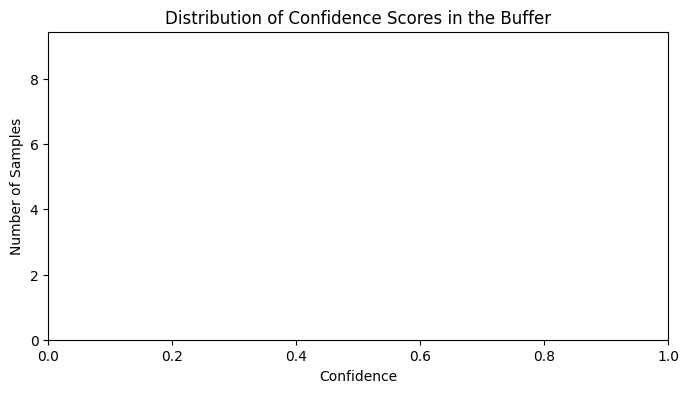

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9987926108912747)]


In [ ]:
# Step 7: Evaluate the Combined System - Analyze Buffer Content

print("\nAnalyzing the content of the Experience Buffer:") # Print a header for the analysis
# Loop through each experience in the buffer
for i, exp in enumerate(buffer.buffer): # Iterate through the buffer's contents
    print(f"Experience {i+1}: Label={exp.label}, Confidence={exp.confidence:.4f}, Seen Count={exp.seen_count}, Timestamp={exp.timestamp}") # Print details of each experience

# Analyze the distribution of labels or confidence scores in the buffer
labels_in_buffer = [exp.label for exp in buffer.buffer] # Extract labels from buffer experiences into a list
confidence_in_buffer = [exp.confidence for exp in buffer.buffer if isinstance(exp.confidence, (int, float))] # Extract confidence scores from buffer experiences into a list

from collections import Counter # Import Counter for counting hashable objects
label_counts = Counter(labels_in_buffer) # Count the occurrences of each label in the buffer

print("\nLabel distribution in the buffer:") # Print a header for label distribution
# Loop through the label counts and print them
for label, count in label_counts.items(): # Iterate through label counts
    print(f"Label {label}: {count} samples") # Print the count for each label

# Visualize the confidence distribution
import matplotlib.pyplot as plt # Import matplotlib.pyplot for plotting

if confidence_in_buffer: # Check if confidence_in_buffer is not empty
  plt.figure(figsize=(8, 4)) # Create a new figure for the plot
  plt.hist(confidence_in_buffer, bins=10) # Create a histogram of confidence scores
  plt.title("Distribution of Confidence Scores in the Buffer") # Set the title of the plot
  plt.xlabel("Confidence") # Set the label for the x-axis
  plt.ylabel("Number of Samples") # Set the label for the y-axis
  plt.xlim(0, 1) # Set the x-axis limits from 0 to 1
  plt.show() # Display the plot
else:
    print("No valid confidence scores found to plot.")


print(f"{confidence_in_buffer}")

In [ ]:
# Initialize Dataset and DataLoader

# Data transformation and dataset loading
# transform is defined in the initial imports cell (775213d9)
dataset = MNIST(root='./data', train=True, download=True, transform=transform) # Load the MNIST training dataset

# Create a DataLoader for the training dataset
# Changed batch_size to 1 to process samples individually for the buffer
loader = DataLoader(dataset, batch_size=1, shuffle=True) # Create a DataLoader for the training dataset

# Task
Compare the performance of the continual learning model with and without the experience buffer and RL agent to prove whether the experience buffer improves efficiency and proficiency.

## Define baseline training

### Subtask:
Adapt the existing training loop to represent a "standard" training scenario without the Experience Buffer and RL agent.


In [ ]:
# Initialize the main model (AdvancedCNN)
model = AdvancedCNN()
model.to(device)
print("Main model (AdvancedCNN) initialized.")

Main model (AdvancedCNN) initialized.


**Reasoning**:
The subtask requires adapting the existing training loop to a standard scenario without the buffer and RL agent. I will copy the training loop from cell `fd67e045`, remove the buffer and RL related code, and keep the standard training logic.



In [ ]:
# Standard Training Loop (without Experience Buffer and RL Agent)

num_epochs = 5 # Define the number of training epochs

# Define Loss Function and Optimizer for the standard model
# Using CrossEntropyLoss and Adam from initial imports
standard_criterion_comparison = nn.CrossEntropyLoss()
standard_optimizer_comparison = Adam(model.parameters(), lr=0.001) # Using 'model' as it's already defined and moved to device

# Load the full MNIST training dataset to create a subset
full_train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Randomly select 5000 indices
num_samples = 5000
total_size = len(full_train_dataset)  # Should be 60000 for MNIST
random_indices = random.sample(range(total_size), num_samples)  # No replacement

limited_train_dataset = Subset(full_train_dataset, random_indices) # Create subset with random indices
# Create a DataLoader for the limited training dataset
# Using a batch size of 64 as in typical training
loader = DataLoader(limited_train_dataset, batch_size=64, shuffle=True)

# Ensure the model is on the correct device and in training mode
model.train() # Set the model to training mode (enables dropout, batch norm updates)
model.to(device) # Ensure model is on the correct device

# List to store loss and confidence for standard training comparison
standard_training_losses = []
standard_confidences_comparison = [] # This won't be populated in standard training but kept for consistency in comparison plotting


print(f"Starting standard training of the main model for {num_epochs} epochs on {num_samples} samples...") # Print message indicating the start of training

# Modified the loop to iterate through the limited_train_dataset using the loader
for epoch in range(num_epochs): # Loop through each epoch
    running_loss = 0.0 # Initialize running loss for printing
    # Iterate through the limited data loader
    for i, (images, labels) in enumerate(loader):
        images = images.to(device) # Move images to the device
        labels = labels.to(device) # Move labels to the device

        # Forward pass
        outputs = model(images) # Perform a forward pass through the model
        loss = standard_criterion_comparison(outputs, labels) # Calculate the loss between model outputs and true labels

        # Backward and optimize
        standard_optimizer_comparison.zero_grad() # Zero the gradients of the optimizer
        loss.backward() # Perform backpropagation to calculate gradients
        standard_optimizer_comparison.step() # Update the model's parameters using the optimizer

        running_loss += loss.item() # Add the current batch's loss to the running loss
        # Standard training loss collection (loss per batch)
        standard_training_losses.append(loss.item()) # Store loss for analysis


        # The original code printed every 100 steps, adjust for potentially smaller loader size
        # print_interval_std = max(1, len(loader) // 10) # Print roughly 10 times per epoch
        if (i+1) % 10 == 0: # Adjusted print interval for smaller dataset
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(loader)}], Loss: {running_loss/10:.4f}') # Print epoch, step, and average loss
            running_loss = 0.0 # Reset running loss
        # Print at the end of each epoch if the loader size is small
        if (i + 1) == len(loader) and (i + 1) % 10 != 0:
             print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(loader)}], Loss: {running_loss / ((i % 10) + 1):.4f}')
             running_loss = 0.0


print("Finished Standard Training of the main model.") # Print message indicating training is finished

# Store the trained model in a variable for comparison
standard_training_model = model # Save the trained model
print("Standard trained model saved to 'standard_training_model'.")

Starting standard training of the main model for 5 epochs on 5000 samples...
Epoch [1/5], Step [10/79], Loss: 1.8758
Epoch [1/5], Step [20/79], Loss: 0.9842
Epoch [1/5], Step [30/79], Loss: 0.5391
Epoch [1/5], Step [40/79], Loss: 0.3498
Epoch [1/5], Step [50/79], Loss: 0.2832
Epoch [1/5], Step [60/79], Loss: 0.2545
Epoch [1/5], Step [70/79], Loss: 0.2119
Epoch [1/5], Step [79/79], Loss: 0.1825
Epoch [2/5], Step [10/79], Loss: 0.1332
Epoch [2/5], Step [20/79], Loss: 0.1765
Epoch [2/5], Step [30/79], Loss: 0.1518
Epoch [2/5], Step [40/79], Loss: 0.1443
Epoch [2/5], Step [50/79], Loss: 0.1534
Epoch [2/5], Step [60/79], Loss: 0.1335
Epoch [2/5], Step [70/79], Loss: 0.0929
Epoch [2/5], Step [79/79], Loss: 0.0707
Epoch [3/5], Step [10/79], Loss: 0.0914
Epoch [3/5], Step [20/79], Loss: 0.1056
Epoch [3/5], Step [30/79], Loss: 0.0640
Epoch [3/5], Step [40/79], Loss: 0.0840
Epoch [3/5], Step [50/79], Loss: 0.0899
Epoch [3/5], Step [60/79], Loss: 0.0736
Epoch [3/5], Step [70/79], Loss: 0.0993
Epo

In [ ]:
# New cell for Baseline Training with Data Collection

# Initialize a new model instance for baseline training
baseline_model_comparison = AdvancedCNN()
baseline_model_comparison.to(device)

# Define Loss Function and Optimizer for the baseline model
baseline_criterion_comparison = nn.CrossEntropyLoss()
baseline_optimizer_comparison = Adam(baseline_model_comparison.parameters(), lr=0.001)

# Lists to store loss and confidence for baseline training comparison
baseline_losses_comparison = []
baseline_confidences_comparison = []

# Standard Training Loop (without Experience Buffer and RL Agent)
num_epochs_comparison = 5 # Define the number of training epochs for comparison

# Load the full MNIST training dataset to create a subset (assuming full_train_dataset is defined)
# If not defined, uncomment the line below:
full_train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)


# Randomly select 5000 indices (using the same random indices as standard training for consistency if desired, or generate new ones)
num_samples = 5000
# If you want to use the same indices as the standard training run:
# Assuming 'random_indices' is available from the previous standard training cell.
# If not, generate new random indices:
# total_size = len(full_train_dataset)
# random_indices = random.sample(range(total_size), num_samples)

limited_train_dataset = Subset(full_train_dataset, random_indices) # Create subset with the selected random indices

# Create a DataLoader for the limited training dataset
# Using batch size 1 to process samples individually for confidence collection
loader_comparison = DataLoader(limited_train_dataset, batch_size=1, shuffle=True)

# Ensure the baseline model is on the correct device and in training mode
baseline_model_comparison.train()
print(f"Starting baseline training (for comparison) of the model for {num_epochs_comparison} epochs on {num_samples} samples...")

for epoch in range(num_epochs_comparison):
    running_loss = 0.0
    for i, (images, labels) in enumerate(loader_comparison):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = baseline_model_comparison(images)
        loss = baseline_criterion_comparison(outputs, labels)

        # Calculate confidence for the current sample
        # Using max probability as a simple measure of confidence
        probs = F.softmax(outputs, dim=1)
        sample_confidence = probs.max(dim=1, keepdim=True)[0].detach().numpy().flatten() # Replaced line
        baseline_confidences_comparison.extend(sample_confidence) # Use extend for numpy array


        # Backward and optimize
        baseline_optimizer_comparison.zero_grad()
        loss.backward()
        baseline_optimizer_comparison.step()

        running_loss += loss.item()
        baseline_losses_comparison.append(loss.item()) # Store loss for analysis

        # Adjusted print interval for dataset size 5000 and batch size 1
        if (i+1) % 100 == 0:
            print(f'Baseline Comparison Epoch [{epoch+1}/{num_epochs_comparison}], Step [{i+1}/{len(loader_comparison)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0
        # Print at the end of the epoch if not printed recently
        if (i + 1) == len(loader_comparison) and (i + 1) % 100 != 0:
             print(f'Baseline Comparison Epoch [{epoch+1}/{num_epochs_comparison}], Step [{i+1}/{len(loader_comparison)}], Loss: {running_loss / ((i % 100) + 1):.4f}')
             running_loss = 0.0


print("Finished Baseline Training (for comparison).")

Starting baseline training (for comparison) of the model for 5 epochs on 5000 samples...
Baseline Comparison Epoch [1/5], Step [100/5000], Loss: 2.5641
Baseline Comparison Epoch [1/5], Step [200/5000], Loss: 1.8498
Baseline Comparison Epoch [1/5], Step [300/5000], Loss: 1.6235
Baseline Comparison Epoch [1/5], Step [400/5000], Loss: 1.2310
Baseline Comparison Epoch [1/5], Step [500/5000], Loss: 1.2146
Baseline Comparison Epoch [1/5], Step [600/5000], Loss: 0.8923
Baseline Comparison Epoch [1/5], Step [700/5000], Loss: 0.8775
Baseline Comparison Epoch [1/5], Step [800/5000], Loss: 0.6572
Baseline Comparison Epoch [1/5], Step [900/5000], Loss: 0.5641
Baseline Comparison Epoch [1/5], Step [1000/5000], Loss: 0.5653
Baseline Comparison Epoch [1/5], Step [1100/5000], Loss: 0.5721
Baseline Comparison Epoch [1/5], Step [1200/5000], Loss: 0.4903
Baseline Comparison Epoch [1/5], Step [1300/5000], Loss: 0.4886
Baseline Comparison Epoch [1/5], Step [1400/5000], Loss: 0.4012
Baseline Comparison Epoc

In [ ]:
# Initialize a new model instance for EB-RL training comparison
eb_rl_model_comparison = AdvancedCNN()
eb_rl_model_comparison.to(device)

# Initialize new RL Actor and Critic for this comparison run
eb_rl_actor_comparison = Actor(state_dim, action_dim).to(device)
eb_rl_critic_comparison = Critic(state_dim).to(device)

# Define Optimizers for Actor and Critic
eb_rl_actor_optimizer_comparison = Adam(eb_rl_actor_comparison.parameters(), lr=0.001)
eb_rl_critic_optimizer_comparison = Adam(eb_rl_critic_comparison.parameters(), lr=0.005)
eb_rl_optimizer_comparison = Adam(eb_rl_model_comparison.parameters(), lr=0.001) # Optimizer for the main model


# Initialize a new Experience Buffer for this comparison run
# The modified sample_batch_images and _simulate_reward are already assigned to the class
eb_rl_buffer_comparison = ExperienceBuffer(model=eb_rl_model_comparison, rl_actor=eb_rl_actor_comparison, rl_critic=eb_rl_critic_comparison, device=device, max_size=10) # Use the same buffer size as before

# Lists to store loss and confidence for EB-RL training comparison
eb_rl_losses_comparison = []
eb_rl_confidences_comparison = []

# Lists to store RL training data for this comparison run
eb_rl_states_comparison = []
eb_rl_actions_comparison = []
eb_rl_rewards_comparison = []

# EB-RL Training Loop (with Experience Buffer and RL Agent)
num_epochs_comparison = 5 # Define the number of training epochs for comparison
rl_train_interval = 50 # Train RL agent every X samples processed (adjust as needed)

# Load the full MNIST training dataset to create a subset (assuming full_train_dataset is defined)
# If not defined, uncomment the line below:
# full_train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Randomly select 5000 indices (using the same random indices as standard/baseline training for consistency if desired, or generate new ones)
num_samples = 5000
# Assuming 'random_indices' is available from the previous standard training cell.
# If not, generate new random indices:
total_size = len(full_train_dataset)
random_indices = random.sample(range(total_size), num_samples)


limited_train_dataset = Subset(full_train_dataset, random_indices) # Create subset with the selected random indices

# Create a DataLoader for the limited training dataset
# Changed batch size to 100 to process samples in batches
loader_comparison = DataLoader(limited_train_dataset, batch_size=1, shuffle=True)


# Ensure the EB-RL model is on the correct device and in training mode
eb_rl_model_comparison.train()
print(f"Starting EB-RL training (for comparison) of the model for {num_epochs_comparison} epochs on {num_samples} samples with batch size 100...") # Updated print message

sample_count = 0 # Counter for samples processed

for epoch in range(num_epochs_comparison):
    running_loss = 0.0
    # Adjusted print interval based on batch size 100 and dataset size 5000
    print_interval = 10 # Print every 10 batches (10 * 100 = 1000 samples)

    for i, (images, labels) in enumerate(loader_comparison):
        images = images.to(device)
        labels = labels.to(device)
        # Since batch size is 100, we keep labels as a tensor

        # --- EB-RL Agent Decision and Buffer Update ---
        # The add method needs to be updated to handle batches and return lists of collected data for each sample in the batch
        # For now, we will iterate through the batch and call add for each sample.
        # This is not ideal for performance, but allows us to see the EB-RL logic with batches.
        # A more efficient implementation would involve batching the state calculation and RL agent decision.
        batch_states = []
        batch_actions = []
        batch_rewards = []
        batch_confidences = [] # Collect confidences for the batch

        for j in range(images.size(0)): # Iterate through each sample in the batch
            img = images[j].unsqueeze(0) # Get a single image and add batch dimension
            label_item = labels[j].item() # Get the scalar label

            state, action, reward = eb_rl_buffer_comparison.add(img, label_item) # Call add with single sample

            # Collect data for RL training for samples that were accepted
            if action == 1:
                 eb_rl_states_comparison.append(state) # Append the state
                 eb_rl_actions_comparison.append(action) # Append the action (0 or 1)
                 eb_rl_rewards_comparison.append(reward) # Append the calculated potential reward

            # Collect confidence for plotting
            # We need to re-calculate confidence for the individual sample here since add processes one by one
            eb_rl_buffer_comparison.model.eval() # Ensure model is in eval mode for confidence calculation
            with torch.no_grad():
                 input_tensor = img.to(eb_rl_buffer_comparison.device) # Use the single image
                 logits = eb_rl_buffer_comparison.model(input_tensor)
                 probs = F.softmax(logits, dim=1)
                 # Confidence for the single sample
                 sample_confidence = probs.max(dim=1, keepdim=True)[0].detach().numpy().flatten()
                 eb_rl_confidences_comparison.extend(sample_confidence) # Use extend for numpy array


        # --- Main Model Training Step ---
        # Train the main model on the current batch
        outputs = eb_rl_model_comparison(images)
        loss = nn.CrossEntropyLoss()(outputs, labels) # Use CrossEntropyLoss

        eb_rl_losses_comparison.append(loss.item()) # Store loss for the batch


        # Backward and optimize for the main model
        eb_rl_model_comparison.zero_grad()
        loss.backward()
        eb_rl_optimizer_comparison.step() # Use the correct optimizer for the main model


        running_loss += loss.item()
        sample_count += images.size(0) # Increment sample counter by batch size (which is 100)


        # --- RL Agent Training Step (Periodically) ---
        # Train the RL agent using the collected data
        if len(eb_rl_states_comparison) >= rl_train_interval: # Train when enough samples are collected
             # print(f"Training RL agent after collecting {len(eb_rl_states_comparison)} samples...")
             # Convert collected lists to tensors
             states_tensor = torch.stack(eb_rl_states_comparison)
             actions_tensor = torch.tensor(eb_rl_actions_comparison)
             rewards_tensor = torch.tensor(eb_rl_rewards_comparison, dtype=torch.float32)

             # Calculate discounted rewards (Returns)
             def calculate_returns(rewards, gamma=0.99):
                 returns = []
                 G = 0
                 for r in reversed(rewards):
                     G = r + gamma * G
                     returns.insert(0, G)
                 return torch.tensor(returns, dtype=torch.float32)


             if rewards_tensor.numel() > 0:
                 returns_tensor = calculate_returns(rewards_tensor.tolist())

                 # Normalize returns
                 returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)

                 # Get value estimates from the critic
                 values_tensor = eb_rl_critic_comparison(states_tensor).squeeze()
                 # Handle case where values_tensor is a scalar
                 if values_tensor.dim() == 0:
                     values_tensor = values_tensor.unsqueeze(0)


                 # Calculate advantages
                 advantages = returns_tensor - values_tensor.detach()

                 # Get the log probabilities of the actions taken by the actor
                 action_probs = eb_rl_actor_comparison(states_tensor)
                 dist = torch.distributions.Categorical(action_probs)
                 log_probs_tensor = dist.log_prob(actions_tensor)


                 # Calculate Actor Loss (Policy Gradient Loss)
                 actor_loss = -(log_probs_tensor * advantages).mean()

                 # Calculate Critic Loss (Mean Squared Error)
                 critic_loss = F.mse_loss(values_tensor, returns_tensor)

                 # Perform Optimization Step for RL agents
                 eb_rl_actor_optimizer_comparison.zero_grad()
                 eb_rl_critic_optimizer_comparison.zero_grad()

                 actor_loss.backward()
                 critic_loss.backward()

                 eb_rl_actor_optimizer_comparison.step()
                 eb_rl_critic_optimizer_comparison.step()

                 # Clear collected RL training data after training
                 eb_rl_states_comparison = []
                 eb_rl_actions_comparison = []
                 eb_rl_rewards_comparison = []

                 # print(f"RL Agent training step completed at sample {sample_count}. Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}")
             else:
                 # print(f"No rewards collected for RL training, skipping RL training step.")
                 pass # Suppress frequent messages


        if (i+1) % print_interval == 0: # Adjusted print interval
            print(f'EB-RL Comparison Epoch [{epoch+1}/{num_epochs_comparison}], Step [{i+1}/{len(loader_comparison)}], Loss: {running_loss/print_interval:.4f}') # Adjusted running loss average
            running_loss = 0.0
        # Print at the end of the epoch if not printed recently
        if (i + 1) == len(loader_comparison) and (i + 1) % print_interval != 0:
             print(f'EB-RL Comparison Epoch [{epoch+1}/{num_epochs_comparison}], Step [{i+1}/{len(loader_comparison)}], Loss: {running_loss / ((i % print_interval) + 1):.4f}')
             running_loss = 0.0


print("Finished EB-RL Training (for comparison) with batch size 100.") # Updated print message

Streaming output truncated to the last 5000 lines.
Epsilon-greedy took random action: Accept
Epsilon-greedy took random action: Accept
Epsilon-greedy took random action: Accept
EB-RL Comparison Epoch [4/5], Step [1660/5000], Loss: 0.0010
Epsilon-greedy took random action: Accept
Epsilon-greedy took random action: Accept
Epsilon-greedy took random action: Accept
Epsilon-greedy took random action: Reject
Epsilon-greedy took random action: Reject
EB-RL Comparison Epoch [4/5], Step [1670/5000], Loss: 0.0215
Epsilon-greedy took random action: Accept
Epsilon-greedy took random action: Accept
Epsilon-greedy took random action: Reject
Epsilon-greedy took random action: Reject
Epsilon-greedy took random action: Accept
EB-RL Comparison Epoch [4/5], Step [1680/5000], Loss: 0.0004
Epsilon-greedy took random action: Accept
Epsilon-greedy took random action: Reject
Epsilon-greedy took random action: Reject
Epsilon-greedy took random action: Accept
Epsilon-greedy took random action: Reject
Epsilon-gr

Standard Training Loss 1/f Curve of Best Fit Coefficients (a, b, c): [6.76242913e+02 2.26045411e+02 8.76911746e-02]
EB-RL Training Loss 1/f Curve of Best Fit Coefficients (a, b, c): [4.11272877e+02 1.45253292e+02 7.80780948e-02]


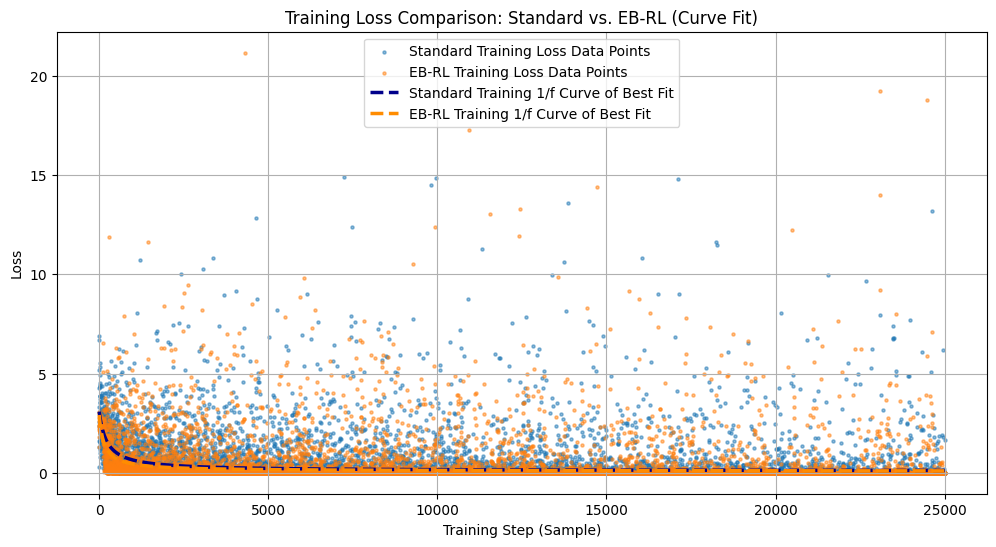

Standard Training Confidence 1/f Curve of Best Fit Coefficients (a, b, c): [317.10232957 406.49347961   0.9896382 ]
EB-RL Training Confidence 1/f Curve of Best Fit Coefficients (a, b, c): [140.35392567 128.62965559   0.98668762]


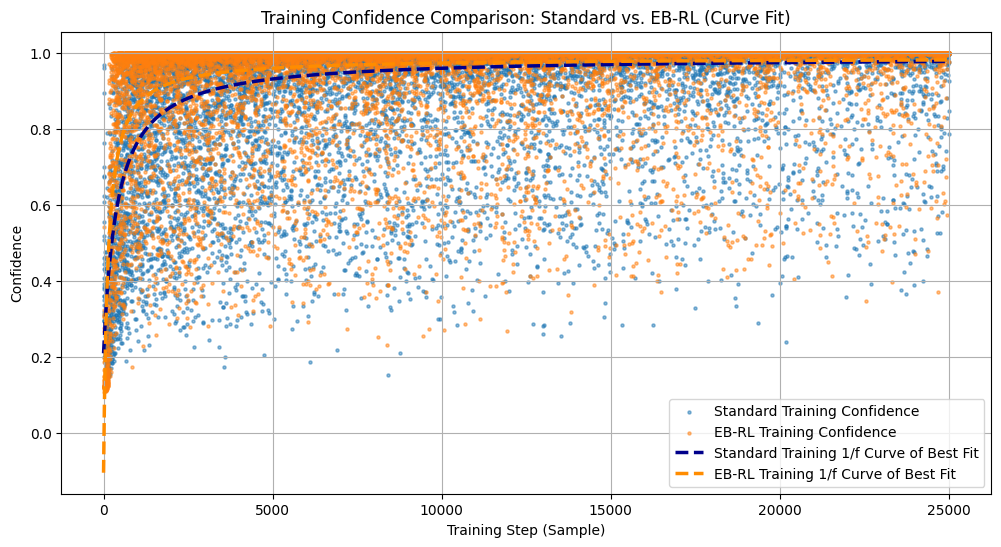

In [ ]:
# Step 8: Compare Standard Training vs. EB-RL Training (Loss Plot - Scatter with Curve of Best Fit)
import pandas as pd # Import pandas for rolling average
from scipy.optimize import curve_fit # Import curve_fit for non-linear fitting

# Function to calculate rolling average (not used in scatter plot, but kept for consistency if needed)
def rolling_average(data, window_size):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().values

# Define log curve function for fitting y = a * log(x + b) + c
def log_func(x, a, b, c):
    # Add a small constant to x to avoid log(0) if x starts from 0 or includes 0
    small_constant = 1e-8
    return a * np.log(x + small_constant + b) + c

# Define 1/f curve function for fitting y = a / (x + b) + c
def inv_f_func(x, a, b, c):
    # Add a small constant to x + b to avoid division by zero
    small_constant = 1e-8
    return a / (x + b + small_constant) + c


# Define log curve function for confidence (inverted since confidence increases) y = a * log(x + b) + c
def log_func_conf(x, a, b, c):
    # Confidence typically increases logarithmically towards 1.
    # 'a' would likely be positive here for an increasing curve.
    small_constant = 1e-8
    return a * np.log(x + small_constant + b) + c

# Define 1/f curve function for confidence y = a / (x + b) + c (increasing)
def inv_f_func_conf(x, a, b, c):
    # Confidence typically increases, so 'a' would be negative for 1/(x+b) form, or use a different form.
    # Let's try a simple increasing form like 1 - a / (x + b)
    small_constant = 1e-8
    return c - a / (x + b + small_constant) # c is the upper bound (close to 1), a is positive


# Ensure both loss lists have data before plotting
if baseline_losses_comparison and eb_rl_losses_comparison:
    plt.figure(figsize=(12, 6)) # Create a figure with a specified size

    # Plot standard training loss as scatter points
    x_baseline = np.arange(len(baseline_losses_comparison))
    plt.scatter(x_baseline, baseline_losses_comparison, label='Standard Training Loss Data Points', alpha=0.5, s=5)

    # Plot EB-RL training loss as scatter points
    x_eb_rl = np.arange(len(eb_rl_losses_comparison))
    plt.scatter(x_eb_rl, eb_rl_losses_comparison, label='EB-RL Training Loss Data Points', alpha=0.5, s=5)

    # Calculate and plot curve of best fit for Standard Training Loss (Try 1/f first, fallback to log)
    if len(baseline_losses_comparison) > 1: # Ensure there's enough data for a line of best fit
        x_vals_baseline = np.arange(len(baseline_losses_comparison)) # Use original indices
        y_vals_baseline = np.array(baseline_losses_comparison)
        try:
            # Try fitting 1/f function
            p0_baseline_invf = [1, 1, y_vals_baseline[-1] if y_vals_baseline.size > 0 else 0.1] # Initial guess: starts high, goes low
            popt_baseline, _ = curve_fit(inv_f_func, x_vals_baseline, y_vals_baseline, p0=p0_baseline_invf, maxfev=10000) # Increased maxfev
            x_curve_baseline = np.linspace(0, len(baseline_losses_comparison) - 1, 1000)
            plt.plot(x_curve_baseline, inv_f_func(x_curve_baseline, *popt_baseline), color='darkblue', linestyle='--', linewidth=2.5, label='Standard Training 1/f Curve of Best Fit')
            print(f"Standard Training Loss 1/f Curve of Best Fit Coefficients (a, b, c): {popt_baseline}")
        except (RuntimeError, ValueError): # Catch RuntimeError or ValueError from curve_fit
            print("Could not fit 1/f curve for Standard Training Loss. Trying log curve.")
            try:
                # Fallback to log function if 1/f fails
                p0_baseline_log = [-1, 1, y_vals_baseline[0] if y_vals_baseline.size > 0 else 1] # Improved initial guess for c
                popt_baseline, _ = curve_fit(log_func, x_vals_baseline, y_vals_baseline, p0=p0_baseline_log, maxfev=10000) # Increased maxfev
                x_curve_baseline = np.linspace(0, len(baseline_losses_comparison) - 1, 1000)
                plt.plot(x_curve_baseline, log_func(x_curve_baseline, *popt_baseline), color='darkblue', linestyle='--', linewidth=2.5, label='Standard Training Log Curve of Best Fit')
                print(f"Standard Training Loss Log Curve of Best Fit Coefficients (a, b, c): {popt_baseline}")
            except (RuntimeError, ValueError):
                 print("Could not fit log curve for Standard Training Loss either.")


    # Calculate and plot curve of best fit for EB-RL Training Loss (Try 1/f first, fallback to log)
    if len(eb_rl_losses_comparison) > 1: # Ensure there's enough data for a line of best fit
        x_vals_eb_rl = np.arange(len(eb_rl_losses_comparison)) # Use original indices
        y_vals_eb_rl = np.array(eb_rl_losses_comparison)
        try:
            # Try fitting 1/f function
            p0_eb_rl_invf = [1, 1, y_vals_eb_rl[-1] if y_vals_eb_rl.size > 0 else 0.1] # Initial guess: starts high, goes low
            popt_eb_rl, _ = curve_fit(inv_f_func, x_vals_eb_rl, y_vals_eb_rl, p0=p0_eb_rl_invf, maxfev=10000) # Increased maxfev
            x_curve_eb_rl = np.linspace(0, len(eb_rl_losses_comparison) - 1, 1000)
            plt.plot(x_curve_eb_rl, inv_f_func(x_curve_eb_rl, *popt_eb_rl), color='darkorange', linestyle='--', linewidth=2.5, label='EB-RL Training 1/f Curve of Best Fit')
            print(f"EB-RL Training Loss 1/f Curve of Best Fit Coefficients (a, b, c): {popt_eb_rl}")
        except (RuntimeError, ValueError): # Catch RuntimeError or ValueError from curve_fit
            print("Could not fit 1/f curve for EB-RL Training Loss. Trying log curve.")
            try:
                # Fallback to log function if 1/f fails
                p0_eb_rl_log = [-1, 1, y_vals_eb_rl[0] if y_vals_eb_rl.size > 0 else 1] # Improved initial guess for c
                popt_eb_rl, _ = curve_fit(log_func, x_vals_eb_rl, y_vals_eb_rl, p0=p0_eb_rl_log, maxfev=10000) # Increased maxfev
                x_curve_eb_rl = np.linspace(0, len(eb_rl_losses_comparison) - 1, 1000)
                plt.plot(x_curve_eb_rl, log_func(x_curve_eb_rl, *popt_eb_rl), color='darkorange', linestyle='--', linewidth=2.5, label='EB-RL Training Log Curve of Best Fit')
                print(f"EB-RL Training Loss Log Curve of Best Fit Coefficients (a, b, c): {popt_eb_rl}")
            except (RuntimeError, ValueError):
                 print("Could not fit log curve for EB-RL Training Loss either.")


    plt.title('Training Loss Comparison: Standard vs. EB-RL (Curve Fit)') # Set the title of the plot
    plt.xlabel('Training Step (Sample)') # Set the x-axis label
    plt.ylabel('Loss') # Set the y-axis label
    plt.legend() # Display the legend
    plt.grid(True) # Add a grid to the plot
    plt.show() # Display the plot
else:
    print("Loss data is not available for plotting. Please ensure both training runs were completed.")

# Step 8 (cont.): Compare Standard Training vs. EB-RL Training (Confidence Plot - Scatter with Curve of Best Fit)

# Ensure both confidence lists have data before plotting
if baseline_confidences_comparison and eb_rl_confidences_comparison:
    plt.figure(figsize=(12, 6)) # Create a figure with a specified size

    # Plot standard training confidence as scatter points
    x_baseline_conf = np.arange(len(baseline_confidences_comparison))
    plt.scatter(x_baseline_conf, baseline_confidences_comparison, label='Standard Training Confidence', alpha=0.5, s=5)

    # Plot EB-RL training confidence as scatter points
    x_eb_rl_conf = np.arange(len(eb_rl_confidences_comparison))
    plt.scatter(x_eb_rl_conf, eb_rl_confidences_comparison, label='EB-RL Training Confidence', alpha=0.5, s=5)

    # Calculate and plot curve of best fit for Standard Training Confidence (Try 1/f first, fallback to log)
    if len(baseline_confidences_comparison) > 1:
        x_vals_baseline_conf = np.arange(len(baseline_confidences_comparison))
        y_vals_baseline_conf = np.array(baseline_confidences_comparison)
        try:
             # Try fitting 1/f function for increasing confidence
            p0_baseline_invf_conf = [1, 1, 1] # Initial guess: approaches 1
            popt_baseline_conf, _ = curve_fit(inv_f_func_conf, x_vals_baseline_conf, y_vals_baseline_conf, p0=p0_baseline_invf_conf, maxfev=10000) # Increased maxfev
            x_curve_baseline_conf = np.linspace(0, len(baseline_confidences_comparison) - 1, 1000)
            plt.plot(x_curve_baseline_conf, inv_f_func_conf(x_curve_baseline_conf, *popt_baseline_conf), color='darkblue', linestyle='--', linewidth=2.5, label='Standard Training 1/f Curve of Best Fit')
            print(f"Standard Training Confidence 1/f Curve of Best Fit Coefficients (a, b, c): {popt_baseline_conf}")
        except (RuntimeError, ValueError): # Catch RuntimeError or ValueError from curve_fit
            print("Could not fit 1/f curve for Standard Training Confidence. Trying log curve.")
            try:
                # Fallback to log function if 1/f fails
                p0_baseline_log_conf = [0.1, 1, y_vals_baseline_conf[0] if y_vals_baseline_conf.size > 0 else 0.5] # Improved initial guess for c
                popt_baseline_conf, _ = curve_fit(log_func_conf, x_vals_baseline_conf, y_vals_baseline_conf, p0=p0_baseline_log_conf, maxfev=10000) # Increased maxfev
                x_curve_baseline_conf = np.linspace(0, len(baseline_confidences_comparison) - 1, 1000)
                plt.plot(x_curve_baseline_conf, log_func_conf(x_curve_baseline_conf, *popt_baseline_conf), color='darkblue', linestyle='--', linewidth=2.5, label='Standard Training Log Curve of Best Fit')
                print(f"Standard Training Confidence Log Curve of Best Fit Coefficients (a, b, c): {popt_baseline_conf}")
            except (RuntimeError, ValueError):
                 print("Could not fit log curve for Standard Training Confidence either.")


    # Calculate and plot curve of best fit for EB-RL Training Confidence (Try 1/f first, fallback to log)
    if len(eb_rl_confidences_comparison) > 1:
        x_vals_eb_rl_conf = np.arange(len(eb_rl_confidences_comparison))
        y_vals_eb_rl_conf = np.array(eb_rl_confidences_comparison)
        try:
            # Try fitting 1/f function for increasing confidence
            p0_eb_rl_invf_conf = [1, 1, 1] # Initial guess: approaches 1
            popt_eb_rl_conf, _ = curve_fit(inv_f_func_conf, x_vals_eb_rl_conf, y_vals_eb_rl_conf, p0=p0_eb_rl_invf_conf, maxfev=10000) # Increased maxfev
            x_curve_eb_rl_conf = np.linspace(0, len(eb_rl_confidences_comparison) - 1, 1000)
            plt.plot(x_curve_eb_rl_conf, inv_f_func_conf(x_curve_eb_rl_conf, *popt_eb_rl_conf), color='darkorange', linestyle='--', linewidth=2.5, label='EB-RL Training 1/f Curve of Best Fit')
            print(f"EB-RL Training Confidence 1/f Curve of Best Fit Coefficients (a, b, c): {popt_eb_rl_conf}")
        except (RuntimeError, ValueError): # Catch RuntimeError or ValueError from curve_fit
            print("Could not fit 1/f curve for EB-RL Training Confidence. Trying log curve.")
            try:
                # Fallback to log function if 1/f fails
                p0_eb_rl_log_conf = [0.1, 1, y_vals_eb_rl_conf[0] if y_vals_eb_rl_conf.size > 0 else 0.5] # Improved initial guess for c
                popt_eb_rl_conf, _ = curve_fit(log_func_conf, x_vals_eb_rl_conf, y_vals_eb_rl_conf, p0=p0_eb_rl_log_conf, maxfev=10000) # Increased maxfev
                x_curve_eb_rl_conf = np.linspace(0, len(eb_rl_confidences_comparison) - 1, 1000)
                plt.plot(x_curve_eb_rl_conf, log_func_conf(x_curve_eb_rl_conf, *popt_eb_rl_conf), color='darkorange', linestyle='--', linewidth=2.5, label='EB-RL Training Log Curve of Best Fit')
                print(f"EB-RL Training Confidence Log Curve of Best Fit Coefficients (a, b, c): {popt_eb_rl_conf}")
            except (RuntimeError, ValueError):
                 print("Could not fit log curve for EB-RL Training Confidence either.")


    plt.title('Training Confidence Comparison: Standard vs. EB-RL (Curve Fit)') # Set the title of the plot
    plt.xlabel('Training Step (Sample)') # Set the x-axis label
    plt.ylabel('Confidence') # Set the y-axis label
    plt.legend() # Display the legend
    plt.grid(True) # Add a grid to the plot
    plt.show() # Display the plot
else:
    print("Confidence data is not available for plotting. Please ensure both training runs were completed and confidence was recorded.")

### Compare Test Accuracy

Evaluate the test accuracy of the model trained with the Experience Buffer and RL agent against the baseline model trained without them.

In [ ]:
# Evaluate the EB-RL trained model on the test set

# Load the MNIST test set (assuming it's already loaded in a previous cell)
# test_dataset is loaded in cell 8f9d24b4
# test_loader is created in cell 8f9d24b4

# Ensure the EB-RL model is on the correct device and in evaluation mode
eb_rl_model_comparison.eval()
eb_rl_model_comparison.to(device)

print("\nEvaluating EB-RL trained model on the test set...")

with torch.no_grad(): # Disable gradient calculation for inference
    correct_eb_rl = 0 # Initialize count of correct predictions for EB-RL model
    total_eb_rl = 0 # Initialize total number of samples for EB-RL model
    for images, labels in test_loader: # Iterate through the test data loader
        images = images.to(device) # Move to device
        labels = labels.to(device) # Move to device
        outputs = eb_rl_model_comparison(images) # Get model outputs (logits)
        _, predicted = torch.max(outputs.data, 1) # Get the predicted labels
        total_eb_rl += labels.size(0) # Add the batch size to the total count
        correct_eb_rl += (predicted == labels).sum().item() # Count correct predictions

print(f'Accuracy of the EB-RL trained model on the {total_eb_rl} test images: {100 * correct_eb_rl / total_eb_rl:.4f}%')

# Evaluate the baseline trained model on the test set (assuming it's already trained)
# baseline_model_comparison is trained in cell 15f843d1

# Ensure the baseline model is on the correct device and in evaluation mode
baseline_model_comparison.eval()
baseline_model_comparison.to(device)

print("\nEvaluating baseline trained model on the test set...")

with torch.no_grad(): # Disable gradient calculation for inference
    correct_baseline = 0 # Initialize count of correct predictions for baseline model
    total_baseline = 0 # Initialize total number of samples for baseline model
    for images, labels in test_loader: # Iterate through the test data loader
        images = images.to(device) # Move to device
        labels = labels.to(device) # Move to device
        outputs = baseline_model_comparison(images) # Get model outputs (logits)
        _, predicted = torch.max(outputs.data, 1) # Get the predicted labels
        total_baseline += labels.size(0) # Add the batch size to the total count
        correct_baseline += (predicted == labels).sum().item() # Count correct predictions

print(f'Accuracy of the baseline trained model on the {total_baseline} test images: {100 * correct_baseline / total_baseline:.4f}%')

# Summarize the comparison
print("\n--- Comparison Summary ---")
print(f"Baseline Model Test Accuracy: {100 * correct_baseline / total_baseline:.4f}%")
print(f"EB-RL Model Test Accuracy:    {100 * correct_eb_rl / total_eb_rl:.4f}%")

if correct_eb_rl > correct_baseline:
    print("\nObservation: The EB-RL model achieved higher accuracy on the test set.")
elif correct_eb_rl < correct_baseline:
    print("\nObservation: The baseline model achieved higher accuracy on the test set.")
else:
    print("\nObservation: Both models achieved the same accuracy on the test set.")


Evaluating EB-RL trained model on the test set...
Accuracy of the EB-RL trained model on the 10000 test images: 97.7800%

Evaluating baseline trained model on the test set...
Accuracy of the baseline trained model on the 10000 test images: 97.6600%

--- Comparison Summary ---
Baseline Model Test Accuracy: 97.6600%
EB-RL Model Test Accuracy:    97.7800%

Observation: The EB-RL model achieved higher accuracy on the test set.


### Evaluate EB-RL Model on Standard Training Set

Evaluate the test accuracy of the model trained with the Experience Buffer and RL agent on the *standard training set*. This will show how well the EB-RL model performs on the data it was trained on.

In [ ]:
# Evaluate and Compare Standard Training vs. EB-RL Training Accuracy (using standard_training_model)

# Ensure both models are on the correct device and in evaluation mode
standard_training_model.eval()
standard_training_model.to(device)
eb_rl_model_comparison.eval()
eb_rl_model_comparison.to(device)

print("\nEvaluating and Comparing Model Accuracies on the Test Set (Standard vs. EB-RL):")

# Evaluate the standard_training_model
correct_standard = 0
total_standard = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = standard_training_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_standard += labels.size(0)
        correct_standard += (predicted == labels).sum().item()

accuracy_standard = 100 * correct_standard / total_standard
print(f'Accuracy of the standard trained model on the {total_standard} test images: {accuracy_standard:.4f}%')

# Evaluate the EB-RL trained model (using eb_rl_model_comparison)
correct_eb_rl = 0
total_eb_rl = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = eb_rl_model_comparison(images)
        _, predicted = torch.max(outputs.data, 1)
        total_eb_rl += labels.size(0)
        correct_eb_rl += (predicted == labels).sum().item()

accuracy_eb_rl = 100 * correct_eb_rl / total_eb_rl
print(f'Accuracy of the EB-RL trained model on the {total_eb_rl} test images: {accuracy_eb_rl:.4f}%')

# Summarize the comparison
print("\n--- Accuracy Comparison Summary ---")
print(f"Standard Model Test Accuracy: {accuracy_standard:.4f}%")
print(f"EB-RL Model Test Accuracy:    {accuracy_eb_rl:.4f}%")

if accuracy_eb_rl > accuracy_standard:
    print("\nObservation: The EB-RL model achieved higher accuracy on the test set.")
elif accuracy_eb_rl < accuracy_standard:
    print("\nObservation: The standard model achieved higher accuracy on the test set.")
else:
    print("\nObservation: Both models achieved the same accuracy on the test set.")


Evaluating and Comparing Model Accuracies on the Test Set (Standard vs. EB-RL):
Accuracy of the standard trained model on the 10000 test images: 97.3000%
Accuracy of the EB-RL trained model on the 10000 test images: 97.7800%

--- Accuracy Comparison Summary ---
Standard Model Test Accuracy: 97.3000%
EB-RL Model Test Accuracy:    97.7800%

Observation: The EB-RL model achieved higher accuracy on the test set.


Standard Training Loss Log Curve of Best Fit Coefficients (a, b, c): [-0.22418674  0.15979677  2.26131825]
EB-RL Training Loss Log Curve of Best Fit Coefficients (a, b, c): [-0.16508804  0.00862067  1.66956106]


/tmp/ipython-input-121-2446371938.py:15: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


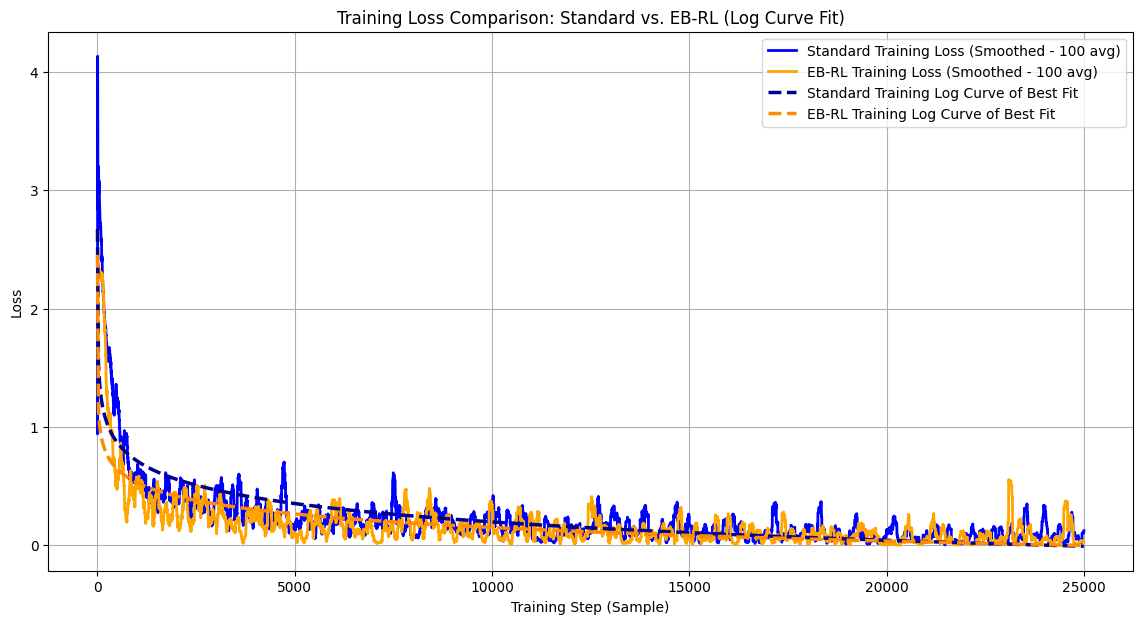

Standard Training Confidence Log Curve of Best Fit Coefficients (a, b, c): [0.07563953 1.33715981 0.24680892]
EB-RL Training Confidence Log Curve of Best Fit Coefficients (a, b, c): [0.0578242  0.00342989 0.42933465]


/tmp/ipython-input-121-2446371938.py:85: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


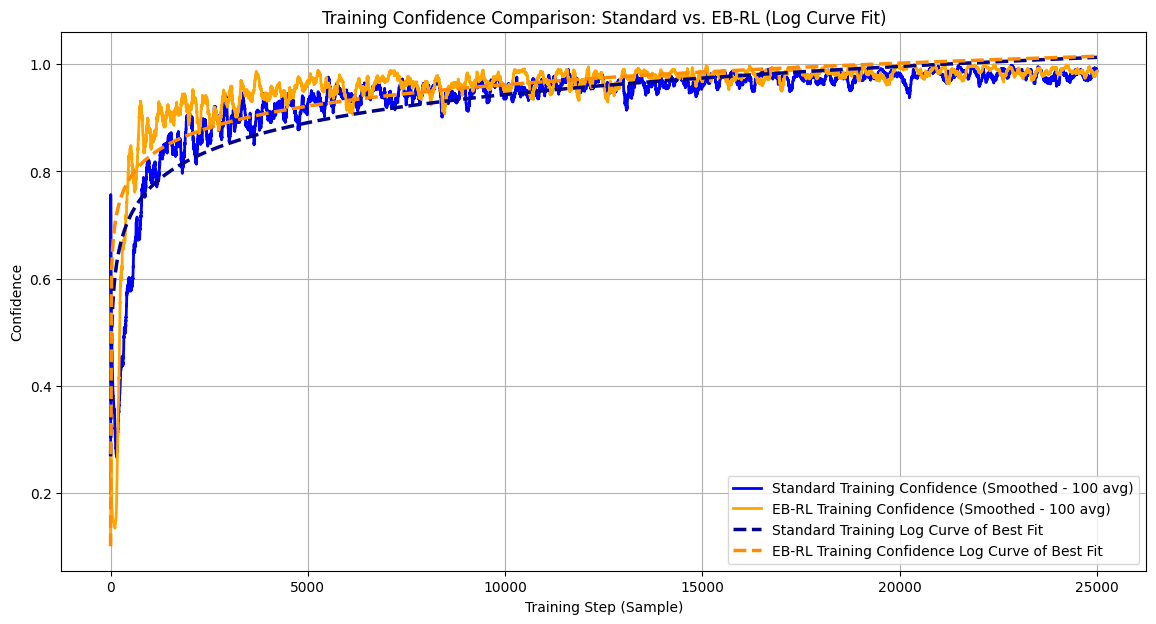

In [ ]:
# Compare Standard Training vs. EB-RL Training (Loss Plot - Smoothed Only)
import pandas as pd # Import pandas for rolling average
from scipy.optimize import curve_fit # Import curve_fit for non-linear fitting

# Function to calculate rolling average
def rolling_average(data, window_size):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().values

# Set window size for rolling average
window_size = 100 # Adjust this value to control the level of smoothing

# Define log curve function for fitting y = a * log(x + b) + c
def log_func(x, a, b, c):
    # Add a small constant to x to avoid log(0) if x starts from 0 or includes 0
    return a * np.log(x + b) + c


# Ensure both loss lists have data before plotting
if baseline_losses_comparison and eb_rl_losses_comparison:
    plt.figure(figsize=(14, 7))

    # Plot rolling average of standard training loss
    baseline_rolling_loss = rolling_average(baseline_losses_comparison, window_size)
    x_baseline = np.arange(len(baseline_rolling_loss)) # Use the length of the smoothed data for the x-axis
    plt.plot(x_baseline, baseline_rolling_loss, color='blue', label=f'Standard Training Loss (Smoothed - {window_size} avg)', linewidth=2)

    # Plot rolling average of EB-RL training loss
    eb_rl_rolling_loss = rolling_average(eb_rl_losses_comparison, window_size)
    x_eb_rl = np.arange(len(eb_rl_losses_comparison)) # Use the length of the smoothed data for the x-axis
    plt.plot(x_eb_rl, eb_rl_rolling_loss, color='orange', label=f'EB-RL Training Loss (Smoothed - {window_size} avg)', linewidth=2)

    # Calculate and plot log curve of best fit for Standard Training Loss
    if len(baseline_losses_comparison) > 1:
        x_vals_baseline = np.arange(len(baseline_losses_comparison)) # Use original indices
        y_vals_baseline = np.array(baseline_losses_comparison)
        # Use curve_fit for non-linear fitting to the log function
        # Provide initial guess for parameters (a, b, c) - these might need tuning
        try:
            popt_baseline, _ = curve_fit(log_func, x_vals_baseline, y_vals_baseline, p0=[-1, 1, 1])
            # Generate x values for the curve
            x_curve_baseline = np.linspace(0, len(baseline_losses_comparison) - 1, 1000)
            plt.plot(x_curve_baseline, log_func(x_curve_baseline, *popt_baseline), color='darkblue', linestyle='--', linewidth=2.5, label='Standard Training Log Curve of Best Fit')
            print(f"Standard Training Loss Log Curve of Best Fit Coefficients (a, b, c): {popt_baseline}")
        except RuntimeError:
            print("Could not fit log curve for Standard Training Loss. Data might not be suitable or initial guess is poor.")
            # Optionally fall back to polynomial fit or skip the curve


    # Calculate and plot log curve of best fit for EB-RL Training Loss
    if len(eb_rl_losses_comparison) > 1:
        x_vals_eb_rl = np.arange(len(eb_rl_losses_comparison)) # Use original indices
        y_vals_eb_rl = np.array(eb_rl_losses_comparison)
        # Use curve_fit for non-linear fitting to the log function
        # Provide initial guess for parameters (a, b, c) - these might need tuning
        try:
            popt_eb_rl, _ = curve_fit(log_func, x_vals_eb_rl, y_vals_eb_rl, p0=[-1, 1, 1])
            # Generate x values for the curve
            x_curve_eb_rl = np.linspace(0, len(eb_rl_losses_comparison) - 1, 1000)
            plt.plot(x_curve_eb_rl, log_func(x_curve_eb_rl, *popt_eb_rl), color='darkorange', linestyle='--', linewidth=2.5, label='EB-RL Training Log Curve of Best Fit')
            print(f"EB-RL Training Loss Log Curve of Best Fit Coefficients (a, b, c): {popt_eb_rl}")
        except RuntimeError:
            print("Could not fit log curve for EB-RL Training Loss. Data might not be suitable or initial guess is poor.")
            # Optionally fall back to polynomial fit or skip the curve


    plt.title('Training Loss Comparison: Standard vs. EB-RL (Log Curve Fit)')
    plt.xlabel('Training Step (Sample)')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # plt.yscale('log') # Log scale for y-axis might not be suitable if log_func fits directly
    plt.show()
else:
    print("Loss data is not available for plotting. Please ensure both training runs were completed.")

# Compare Standard Training vs. EB-RL Training (Confidence Plot - Smoothed Only)
# Applying log curve fit to confidence as well.

# Define log curve function for confidence (inverted since confidence increases) y = a * log(x + b) + c
def log_func_conf(x, a, b, c):
    # Confidence typically increases logarithmically towards 1.
    # A form like 1 - exp(-k * x) or similar might be more intuitive,
    # but sticking to the request for a log curve y = a * log(x+b) + c
    # 'a' would likely be positive here for an increasing curve.
     return a * np.log(x + b) + c


# Ensure both confidence lists have data before plotting
if baseline_confidences_comparison and eb_rl_confidences_comparison:
    plt.figure(figsize=(14, 7))

    # Plot rolling average of standard training confidence
    baseline_rolling_conf = rolling_average(baseline_confidences_comparison, window_size)
    x_baseline_conf = np.arange(len(baseline_rolling_conf)) # Use the length of the smoothed data for the x-axis
    plt.plot(x_baseline_conf, baseline_rolling_conf, color='blue', label=f'Standard Training Confidence (Smoothed - {window_size} avg)', linewidth=2)

    # Plot rolling average of EB-RL training confidence
    eb_rl_rolling_conf = rolling_average(eb_rl_confidences_comparison, window_size)
    x_eb_rl_conf = np.arange(len(eb_rl_confidences_comparison)) # Use the length of the smoothed data for the x-axis
    plt.plot(x_eb_rl_conf, eb_rl_rolling_conf, color='orange', label=f'EB-RL Training Confidence (Smoothed - {window_size} avg)', linewidth=2)

    # Calculate and plot log curve of best fit for Standard Training Confidence
    if len(baseline_confidences_comparison) > 1:
        x_vals_baseline_conf = np.arange(len(baseline_confidences_comparison)) # Use original indices
        y_vals_baseline_conf = np.array(baseline_confidences_comparison)
         # Use curve_fit for non-linear fitting to the log function
        # Provide initial guess for parameters (a, b, c) - these might need tuning
        # 'a' positive for increasing confidence, 'c' could be initial confidence
        try:
            popt_baseline_conf, _ = curve_fit(log_func_conf, x_vals_baseline_conf, y_vals_baseline_conf, p0=[0.1, 1, 0.5])
            # Generate x values for the curve
            x_curve_baseline_conf = np.linspace(0, len(baseline_confidences_comparison) - 1, 1000)
            plt.plot(x_curve_baseline_conf, log_func_conf(x_curve_baseline_conf, *popt_baseline_conf), color='darkblue', linestyle='--', linewidth=2.5, label='Standard Training Log Curve of Best Fit')
            print(f"Standard Training Confidence Log Curve of Best Fit Coefficients (a, b, c): {popt_baseline_conf}")
        except RuntimeError:
            print("Could not fit log curve for Standard Training Confidence. Data might not be suitable or initial guess is poor.")
            # Optionally fall back to polynomial fit or skip the curve


    # Calculate and plot log curve of best fit for EB-RL Training Confidence
    if len(eb_rl_confidences_comparison) > 1:
        x_vals_eb_rl_conf = np.arange(len(eb_rl_confidences_comparison)) # Use original indices
        y_vals_eb_rl_conf = np.array(eb_rl_confidences_comparison)
        # Use curve_fit for non-linear fitting to the log function
        # Provide initial guess for parameters (a, b, c) - these might need tuning
        # 'a' positive for increasing confidence, 'c' could be initial confidence
        try:
            popt_eb_rl_conf, _ = curve_fit(log_func_conf, x_vals_eb_rl_conf, y_vals_eb_rl_conf, p0=[0.1, 1, 0.5])
            # Generate x values for the curve
            x_curve_eb_rl_conf = np.linspace(0, len(eb_rl_confidences_comparison) - 1, 1000)
            plt.plot(x_curve_eb_rl_conf, log_func_conf(x_curve_eb_rl_conf, *popt_eb_rl_conf), color='darkorange', linestyle='--', linewidth=2.5, label='EB-RL Training Confidence Log Curve of Best Fit')
            print(f"EB-RL Training Confidence Log Curve of Best Fit Coefficients (a, b, c): {popt_eb_rl_conf}")
        except RuntimeError:
            print("Could not fit log curve for EB-RL Training Confidence. Data might not be suitable or initial guess is poor.")
            # Optionally fall back to polynomial fit or skip the curve


    plt.title('Training Confidence Comparison: Standard vs. EB-RL (Log Curve Fit)')
    plt.xlabel('Training Step (Sample)')
    plt.ylabel('Confidence')
    plt.legend()
    plt.grid(True)
    # plt.yscale('log') # Log scale for y-axis might not be suitable for confidence (0 to 1)
    plt.show()
else:
    print("Confidence data is not available for plotting. Please ensure both training runs were completed and confidence was recorded.")

/tmp/ipython-input-122-327302175.py:12: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


Standard Training Loss Log Curve of Best Fit Coefficients (a, b, c): [-0.22418674  0.15979677  2.26131825]
EB-RL Training Loss Log Curve of Best Fit Coefficients (a, b, c): [-0.16508804  0.00862067  1.66956106]


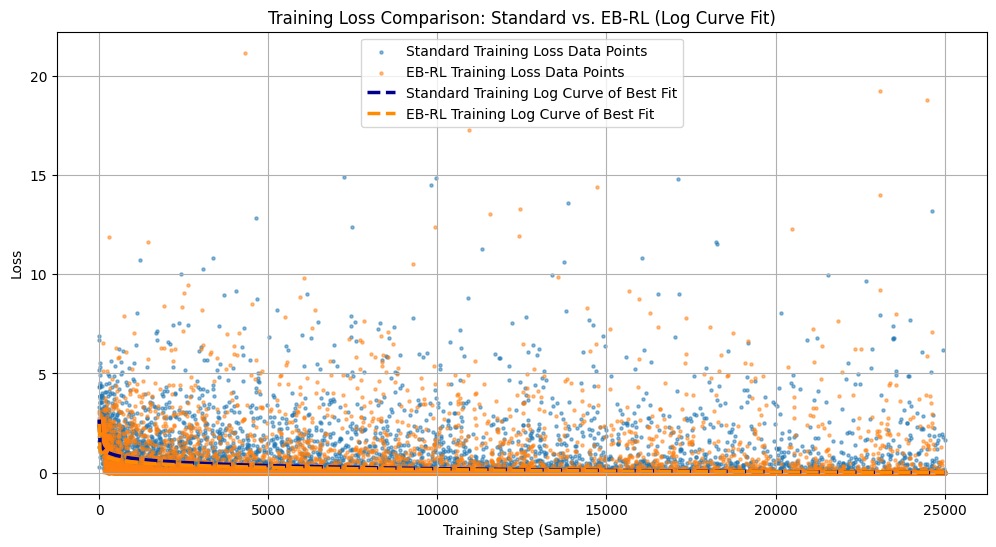

Standard Training Confidence Log Curve of Best Fit Coefficients (a, b, c): [0.07563953 1.33715981 0.24680892]
EB-RL Training Confidence Log Curve of Best Fit Coefficients (a, b, c): [0.0578242  0.00342989 0.42933465]


/tmp/ipython-input-122-327302175.py:18: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


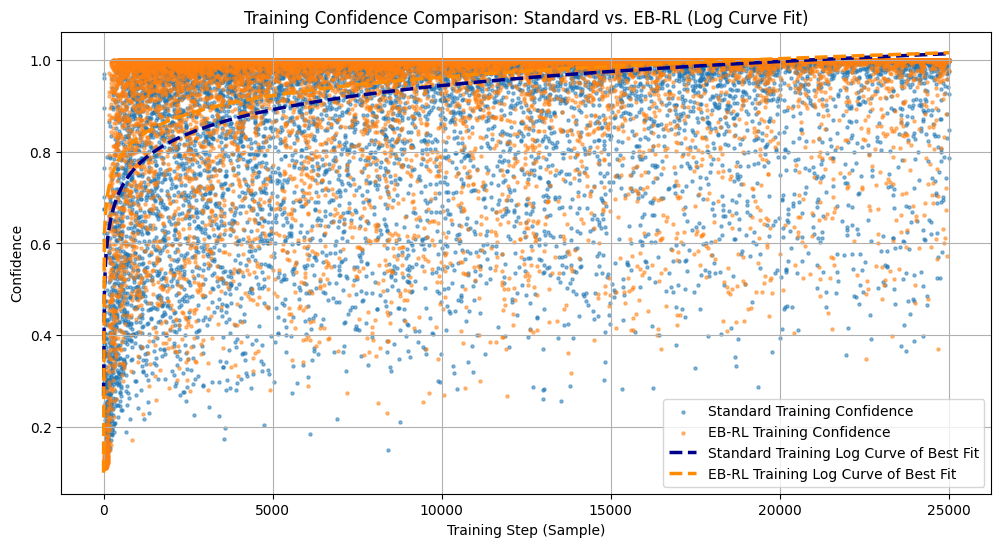

In [ ]:
# Compare Standard Training vs. EB-RL Training (Loss Plot - Scatter with Line of Best Fit)
import pandas as pd # Import pandas for rolling average
from scipy.optimize import curve_fit # Import curve_fit for non-linear fitting

# Function to calculate rolling average (not used in scatter plot, but kept for consistency if needed)
def rolling_average(data, window_size):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().values

# Define log curve function for fitting y = a * log(x + b) + c
def log_func(x, a, b, c):
    # Add a small constant to x to avoid log(0) if x starts from 0 or includes 0
    return a * np.log(x + b) + c

# Define log curve function for confidence (inverted since confidence increases) y = a * log(x + b) + c
def log_func_conf(x, a, b, c):
    # Confidence typically increases logarithmically towards 1.
    # 'a' would likely be positive here for an increasing curve.
     return a * np.log(x + b) + c


# Ensure both loss lists have data before plotting
if baseline_losses_comparison and eb_rl_losses_comparison:
    plt.figure(figsize=(12, 6)) # Create a figure with a specified size

    # Plot standard training loss as scatter points
    x_baseline = np.arange(len(baseline_losses_comparison))
    plt.scatter(x_baseline, baseline_losses_comparison, label='Standard Training Loss Data Points', alpha=0.5, s=5)

    # Plot EB-RL training loss as scatter points
    x_eb_rl = np.arange(len(eb_rl_losses_comparison))
    plt.scatter(x_eb_rl, eb_rl_losses_comparison, label='EB-RL Training Loss Data Points', alpha=0.5, s=5)

    # Calculate and plot log curve of best fit for Standard Training Loss
    if len(baseline_losses_comparison) > 1: # Ensure there's enough data for a line of best fit
        x_vals_baseline = np.arange(len(baseline_losses_comparison)) # Use original indices
        y_vals_baseline = np.array(baseline_losses_comparison)
        try:
            popt_baseline, _ = curve_fit(log_func, x_vals_baseline, y_vals_baseline, p0=[-1, 1, 1])
            x_curve_baseline = np.linspace(0, len(baseline_losses_comparison) - 1, 1000)
            plt.plot(x_curve_baseline, log_func(x_curve_baseline, *popt_baseline), color='darkblue', linestyle='--', linewidth=2.5, label='Standard Training Log Curve of Best Fit')
            print(f"Standard Training Loss Log Curve of Best Fit Coefficients (a, b, c): {popt_baseline}")
        except RuntimeError:
            print("Could not fit log curve for Standard Training Loss.")


    # Calculate and plot log curve of best fit for EB-RL Training Loss
    if len(eb_rl_losses_comparison) > 1: # Ensure there's enough data for a line of best fit
        x_vals_eb_rl = np.arange(len(eb_rl_losses_comparison)) # Use original indices
        y_vals_eb_rl = np.array(eb_rl_losses_comparison)
        try:
            popt_eb_rl, _ = curve_fit(log_func, x_vals_eb_rl, y_vals_eb_rl, p0=[-1, 1, 1])
            x_curve_eb_rl = np.linspace(0, len(eb_rl_losses_comparison) - 1, 1000)
            plt.plot(x_curve_eb_rl, log_func(x_curve_eb_rl, *popt_eb_rl), color='darkorange', linestyle='--', linewidth=2.5, label='EB-RL Training Log Curve of Best Fit')
            print(f"EB-RL Training Loss Log Curve of Best Fit Coefficients (a, b, c): {popt_eb_rl}")
        except RuntimeError:
             print("Could not fit log curve for EB-RL Training Loss.")


    plt.title('Training Loss Comparison: Standard vs. EB-RL (Log Curve Fit)') # Set the title of the plot
    plt.xlabel('Training Step (Sample)') # Set the x-axis label
    plt.ylabel('Loss') # Set the y-axis label
    plt.legend() # Display the legend
    plt.grid(True) # Add a grid to the plot
    plt.show() # Display the plot
else:
    print("Loss data is not available for plotting. Please ensure both training runs were completed.")

# Step 8 (cont.): Compare Standard Training vs. EB-RL Training (Confidence Plot)

# Ensure both confidence lists have data before plotting
if baseline_confidences_comparison and eb_rl_confidences_comparison:
    plt.figure(figsize=(12, 6)) # Create a figure with a specified size

    # Plot standard training confidence as scatter points
    x_baseline_conf = np.arange(len(baseline_confidences_comparison))
    plt.scatter(x_baseline_conf, baseline_confidences_comparison, label='Standard Training Confidence', alpha=0.5, s=5)

    # Plot EB-RL training confidence as scatter points
    x_eb_rl_conf = np.arange(len(eb_rl_confidences_comparison))
    plt.scatter(x_eb_rl_conf, eb_rl_confidences_comparison, label='EB-RL Training Confidence', alpha=0.5, s=5)

    # Calculate and plot log curve of best fit for Standard Training Confidence
    if len(baseline_confidences_comparison) > 1:
        x_vals_baseline_conf = np.arange(len(baseline_confidences_comparison))
        y_vals_baseline_conf = np.array(baseline_confidences_comparison)
        try:
            popt_baseline_conf, _ = curve_fit(log_func_conf, x_vals_baseline_conf, y_vals_baseline_conf, p0=[0.1, 1, 0.5])
            x_curve_baseline_conf = np.linspace(0, len(baseline_confidences_comparison) - 1, 1000)
            plt.plot(x_curve_baseline_conf, log_func_conf(x_curve_baseline_conf, *popt_baseline_conf), color='darkblue', linestyle='--', linewidth=2.5, label='Standard Training Log Curve of Best Fit')
            print(f"Standard Training Confidence Log Curve of Best Fit Coefficients (a, b, c): {popt_baseline_conf}")
        except RuntimeError:
             print("Could not fit log curve for Standard Training Confidence.")

    # Calculate and plot log curve of best fit for EB-RL Training Confidence
    if len(eb_rl_confidences_comparison) > 1:
        x_vals_eb_rl_conf = np.arange(len(eb_rl_confidences_comparison))
        y_vals_eb_rl_conf = np.array(eb_rl_confidences_comparison)
        try:
            popt_eb_rl_conf, _ = curve_fit(log_func_conf, x_vals_eb_rl_conf, y_vals_eb_rl_conf, p0=[0.1, 1, 0.5])
            x_curve_eb_rl_conf = np.linspace(0, len(eb_rl_confidences_comparison) - 1, 1000)
            plt.plot(x_curve_eb_rl_conf, log_func_conf(x_curve_eb_rl_conf, *popt_eb_rl_conf), color='darkorange', linestyle='--', linewidth=2.5, label='EB-RL Training Log Curve of Best Fit')
            print(f"EB-RL Training Confidence Log Curve of Best Fit Coefficients (a, b, c): {popt_eb_rl_conf}")
        except RuntimeError:
             print("Could not fit log curve for EB-RL Training Confidence.")


    plt.title('Training Confidence Comparison: Standard vs. EB-RL (Log Curve Fit)') # Set the title of the plot
    plt.xlabel('Training Step (Sample)') # Set the x-axis label
    plt.ylabel('Confidence') # Set the y-axis label
    plt.legend() # Display the legend
    plt.grid(True) # Add a grid to the plot
    plt.show() # Display the plot
else:
    print("Confidence data is not available for plotting. Please ensure both training runs were completed and confidence was recorded.")

Accuracy of the Standard (Baseline) model on the 10000 test images: 97.66%
Accuracy of the EB-RL model on the 10000 test images: 97.78%


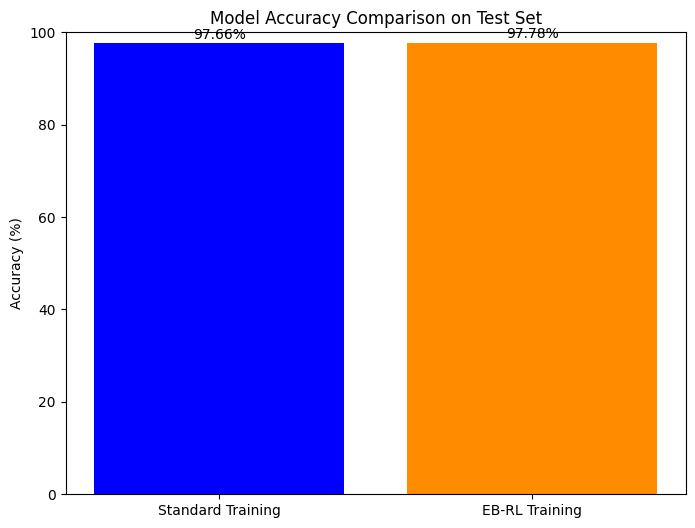

In [ ]:
# Evaluate the accuracy of the Standard (Baseline) and EB-RL models on the test set

def evaluate_model_accuracy(model, data_loader, device):
    model.eval() # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad(): # Disable gradient calculation
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Assuming test_loader is already defined and loaded with the MNIST test set
# If not, uncomment and run the following lines:
# test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Evaluate baseline model accuracy
# Assuming baseline_model_comparison is already trained
baseline_accuracy_comparison = evaluate_model_accuracy(baseline_model_comparison, test_loader, device)
print(f'Accuracy of the Standard (Baseline) model on the 10000 test images: {baseline_accuracy_comparison:.2f}%')

# Evaluate EB-RL model accuracy
# Assuming eb_rl_model_comparison is already trained
eb_rl_accuracy_comparison = evaluate_model_accuracy(eb_rl_model_comparison, test_loader, device)
print(f'Accuracy of the EB-RL model on the 10000 test images: {eb_rl_accuracy_comparison:.2f}%')

# Plot the accuracy comparison

import matplotlib.pyplot as plt
import numpy as np

labels = ['Standard Training', 'EB-RL Training']
accuracies = [baseline_accuracy_comparison, eb_rl_accuracy_comparison]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'darkorange'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison on Test Set')
plt.ylim(0, 100) # Set y-axis limit from 0 to 100
# Add text labels for accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f'{acc:.2f}%', ha='center')

plt.show()